#  Music genre prediction [M1_26DS+]

# Введение

##    ЦЕЛЬ ПРОЕКТА: разработать модель для предсказания музыкальных жанров.

##    ДАННЫЕ: 

  - Тренировочный набор даных - информация (~20000) о музыкальных треках с указанием жанра.
  
  - Тестовый набор - информация (~5000) о музыкальных треках без указания жанра.
  
  - Файл предсказаний в правильном формате.
    
  
## ПЛАН ВЫПОЛНЕНИЯ ПРОЕКТА:

  - Загрузить и изучить данные;
  
  - Провести предобработку; 
  
  - Провести разведочный анализ данных;
  
  - Разработать новые синтетические признаки;
  
  - Проверить признаки на мультиколлинеарность;
  
  - Отобрать финальный набор обучающих признаков;
  
  - Выбрать и обучить модели;
  
  - Оценить качество предсказания лучшей модели;
  
  - Провести анализ важности ее признаков;
  
  - Сформулировать и оформить промежуточный и общий выводы.

# Загрузка данных и библиотек

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost
from catboost import CatBoostClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score,precision_score,f1_score

# настраиваем оторбражение 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
# загружаем данные
data_train = pd.read_csv('../Downloads/music-genre-prediction/kaggle_music_genre_train.csv', sep=',')
data_test = pd.read_csv('../Downloads/music-genre-prediction/kaggle_music_genre_test.csv', sep=',')
sample_submit = pd.read_csv('../Downloads/music-genre-prediction/sample_submit.csv', sep=',')

In [3]:
# датасет для загрузки финального предсказания
sample_submit.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime


In [4]:
# знакомимся с тренировочными данными 
data_train.info()
# выбираем случайные 5 строк 
display(data_train.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
7814,61560.0,Waiting for Superman,0.002900,0.555,266960.0,0.682,0.000000,C,0.0662,-5.711,Major,0.0269,105.987,4-Apr,0.383,Rock
2401,46283.0,Diazepam,0.459000,0.639,-1.0,0.684,0.000593,G,0.0815,-7.804,Major,0.0272,NaN,4-Apr,0.288,Alternative
4887,20942.0,Car Service,0.079900,0.531,180441.0,0.746,0.000000,G,0.0954,-3.968,Major,0.1520,72.983,4-Apr,0.425,Rap
867,76674.0,Green Poison,0.002090,0.792,431788.0,0.497,0.027200,A,0.2230,-7.465,Major,0.0818,69.989,4-Apr,0.254,Electronic
7761,45285.0,Madder,0.000456,0.625,320333.0,0.843,0.000761,B,0.1790,-5.163,Major,0.0695,117.949,4-Apr,0.717,Electronic


In [5]:
# знакомимся с тестовыми данными
data_test.info()
# выбираем случайные 5 строк 
display(data_test.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
2892,88574,Movin' on Up,0.084600,0.508,230533.0,0.808,0.000727,C,0.0719,-12.496,Minor,0.0403,94.255,4-Apr,0.209
4026,49452,Level Up,0.000656,0.630,257143.0,0.948,0.000504,C#,0.0678,-4.557,Major,0.1540,139.991,4-Apr,0.808
316,53364,Tsunami,0.001450,0.826,187933.0,0.457,0.000000,C#,0.1400,-10.324,Major,0.3710,156.001,4-Apr,0.530
4512,56423,Pt. 2,0.577000,0.670,130293.0,0.724,0.000000,B,0.7890,-4.141,Major,0.3610,145.105,4-Apr,0.285
1098,70467,Man Research (Clapper),0.127000,0.625,272947.0,0.716,0.478000,G#,0.0842,-11.376,Minor,0.0592,95.739,4-Apr,0.838


## Вывод

- Данне загружены и изучены:
  
   - В данных присутствуют пропуски; 
   
   - Данные в нескольких столбцах имеют строковый тип.

# Предобработка 

## Аномалии

In [6]:
# уменьшаем размерность duration_ms - переведем в секунды
data_train['duration_ms'] = data_train['duration_ms']/1000
data_test['duration_ms'] = data_test['duration_ms']/1000

In [7]:
# смотрим уникальные значения в столбцах с нечисловыми данными в обучающем наборе
columns = data_train.select_dtypes(include='object')
def values_unique(data):
    for column in columns:
        values = data[column].unique()
        print('Уникальные значения столбца:', column)
        print(values)
        print()
           
values_unique(data_train)

Уникальные значения столбца: track_name
['Highwayman' 'Toes Across The Floor' 'First Person on Earth' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']

Уникальные значения столбца: key
['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']

Уникальные значения столбца: mode
['Major' 'Minor' nan]

Уникальные значения столбца: obtained_date
['4-Apr' '3-Apr' '5-Apr' '1-Apr']

Уникальные значения столбца: music_genre
['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']



In [8]:
# смотрим уникальные значения в столбцах с нечисловыми данными в тестовом наборе
columns = data_test.select_dtypes(include='object')
values_unique(data_test)

Уникальные значения столбца: track_name
['Low Class Conspiracy' 'The Hunter' 'Hate Me Now' ... 'Bipolar'
 'Dead - NGHTMRE Remix'
 'A Night In Tunisia - Remastered 1998 / Rudy Van Gelder Edition']

Уникальные значения столбца: key
['A#' 'G#' 'A' 'B' 'D' 'F#' 'F' 'G' 'C' nan 'D#' 'C#' 'E']

Уникальные значения столбца: mode
['Minor' 'Major' nan]

Уникальные значения столбца: obtained_date
['4-Apr' '3-Apr' '5-Apr' '1-Apr']



'Распределение числовых значений в обучающем наборе данных'

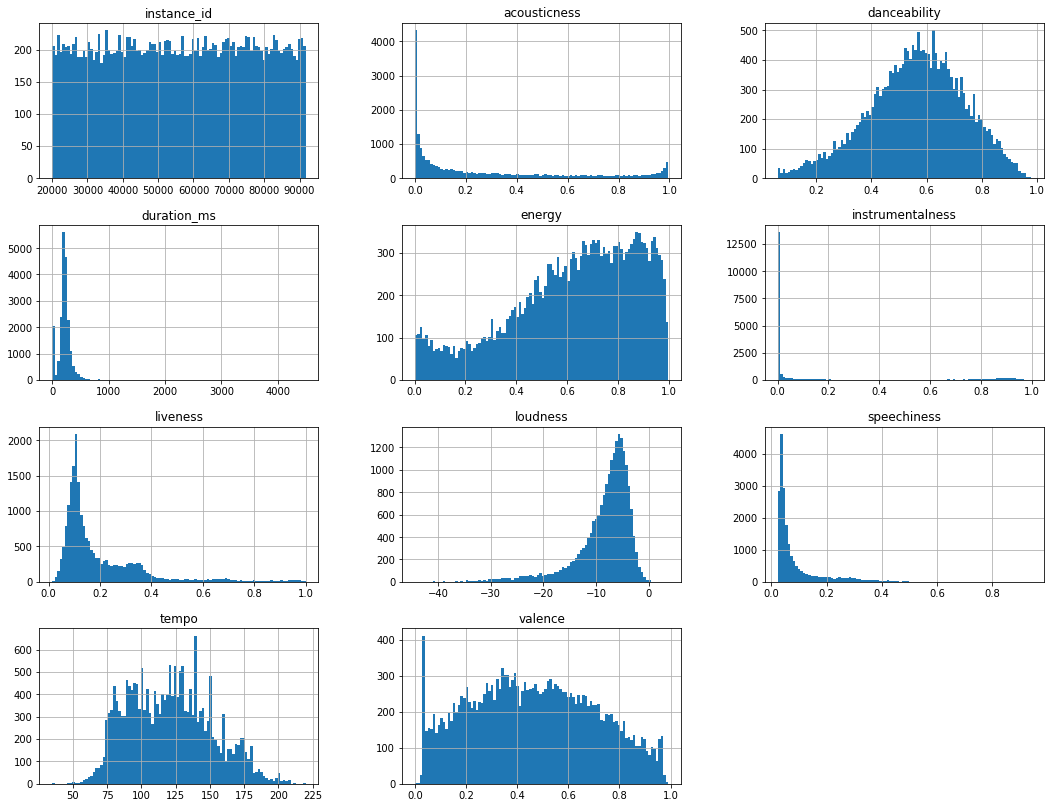

In [9]:
# смотрим столбцы с числовыми данными обучающего набора на графиках
display('Распределение числовых значений в обучающем наборе данных')
data_train.hist(bins=100,figsize=[18,14]);

'Распределение числовых значений в тестовом наборе данных'

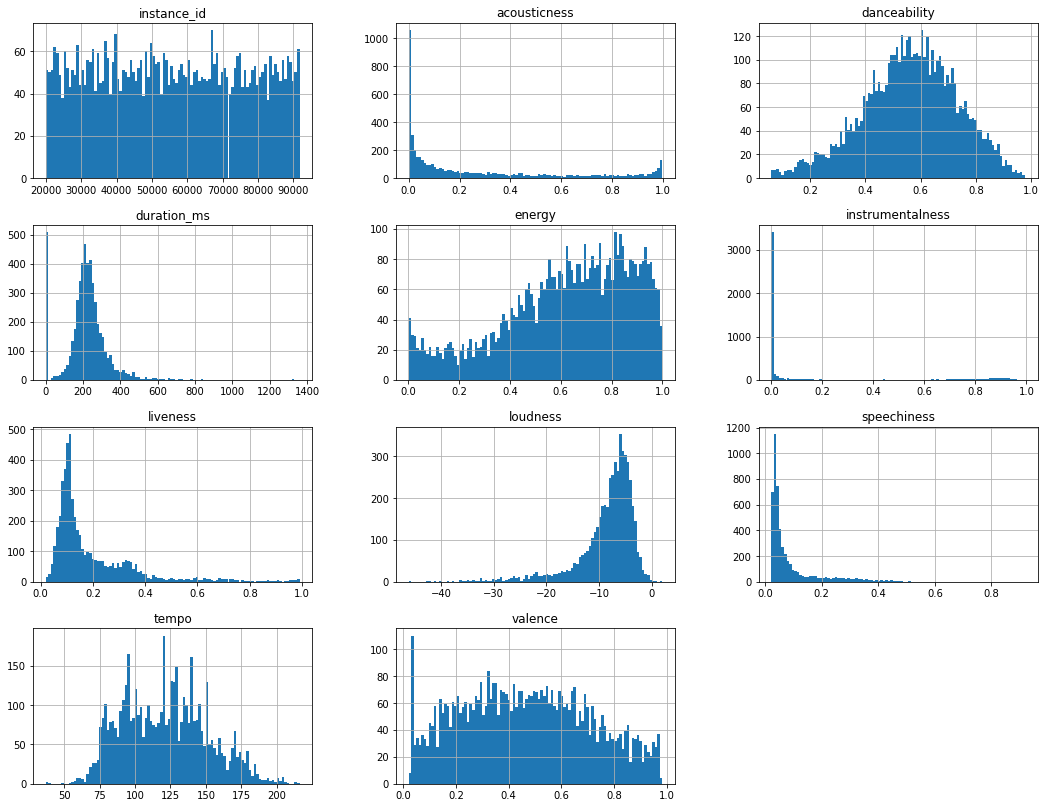

In [10]:
# смотрим столбцы с числовыми данными тестового набора на графиках
display('Распределение числовых значений в тестовом наборе данных')
data_test.hist(bins=100,figsize=[18,14]);

In [11]:
# смотрим уникальные значения в столбцах с числовыми данными с возможными аномалиями в обучающем наборе
columns = ['acousticness', 'duration_ms', 'instrumentalness']
def values_unique(data):
    for column in columns:
        values = data[column].value_counts(normalize=True).head()
        print('Распределение значений в столбце:', column)
        print(values)
        print()
           
values_unique(data_train)

Распределение значений в столбце: acousticness
0.994    0.003727
0.995    0.003727
0.991    0.002795
0.992    0.002697
0.993    0.002599
Name: acousticness, dtype: float64

Распределение значений в столбце: duration_ms
-0.001      0.098509
 192.000    0.000785
 240.000    0.000785
 180.000    0.000637
 182.400    0.000490
Name: duration_ms, dtype: float64

Распределение значений в столбце: instrumentalness
0.000    0.293125
0.905    0.001324
0.892    0.001275
0.898    0.001226
0.912    0.001226
Name: instrumentalness, dtype: float64



In [12]:
# смотрим уникальные значения в столбцах с числовыми данными с возможными аномалиями в тестовом наборе
values_unique(data_test)

Распределение значений в столбце: acousticness
0.995    0.005295
0.989    0.002942
0.991    0.002942
0.994    0.002942
0.992    0.002550
Name: acousticness, dtype: float64

Распределение значений в столбце: duration_ms
-0.001      0.099823
 162.333    0.000981
 186.000    0.000784
 223.267    0.000784
 268.800    0.000784
Name: duration_ms, dtype: float64

Распределение значений в столбце: instrumentalness
0.000    0.296136
0.862    0.001765
0.923    0.001765
0.916    0.001569
0.887    0.001569
Name: instrumentalness, dtype: float64



In [13]:
# смотрим распределение значений в столбце duration_ms в обучающем наборе
data_train['duration_ms'].describe()

count    20394.000000
mean       220.375425
std        126.728326
min         -0.001000
25%        177.517000
50%        219.533000
75%        266.000000
max       4497.994000
Name: duration_ms, dtype: float64

In [14]:
# смотрим распределение значений в столбце duration_ms в тестовом наборе
data_test['duration_ms'].describe()

count    5099.000000
mean      217.397408
std       115.637408
min        -0.001000
25%       173.733500
50%       217.500000
75%       264.247000
max      1360.027000
Name: duration_ms, dtype: float64

## Обработка столбца с датами

In [15]:
# удаляем малоинформативные столбцы 
df_train = data_train.drop(['obtained_date'], axis=1)
df_test = data_test.drop(['obtained_date'], axis=1)

# проверяем
data_train.info()
print()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

## Дубликаты

In [16]:
# выводим названия колонок
df_train.columns

Index(['instance_id', 'track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'music_genre'],
      dtype='object')

In [17]:
# выбираем колонки для поиска дубликатов
dup_col = df_train.columns[2:]

In [18]:
# ищем дубликаты в данных
df_train.duplicated(dup_col).sum()

7

In [19]:
# смотрим строки-дубликаты в тренировочном наборе 
df_train.loc[df_train.duplicated(dup_col, keep=False)].sort_values(by='acousticness')

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
4945,61145.0,Extreme Ways (Bourne's Legacy),0.000417,0.466,290.827,0.828,0.20500,B,0.335,-7.898,Minor,0.0518,104.495,0.299,Electronic
18071,23448.0,Extreme Ways (Bourne's Legacy) - Original Version,0.000417,0.466,290.827,0.828,0.20500,B,0.335,-7.898,Minor,0.0518,104.495,0.299,Electronic
12175,82029.0,TTU (Too Turnt Up) (feat. Waka Flocka Flame),0.003990,0.579,241.702,0.790,0.13500,NaN,0.101,-4.683,Minor,0.0468,144.998,0.233,Electronic
15429,78576.0,TTU (Too Turnt Up),0.003990,0.579,241.702,0.790,0.13500,NaN,0.101,-4.683,Minor,0.0468,144.998,0.233,Electronic
10089,21594.0,Forever - FuntCase Remix,0.013400,0.312,321.600,0.981,0.06190,F,0.289,-2.788,Minor,0.3800,149.600,0.043,Electronic
15954,22037.0,Forever - Funtcase Remix,0.013400,0.312,321.600,0.981,0.06190,F,0.289,-2.788,Minor,0.3800,149.600,0.043,Electronic
8332,27101.0,Back To The Future (feat. ProbCause),0.018600,0.583,180.000,0.841,0.00000,D,0.105,-3.665,Major,0.1900,90.646,0.495,Electronic
9890,68462.0,Back To The Future,0.018600,0.583,180.000,0.841,0.00000,D,0.105,-3.665,Major,0.1900,90.646,0.495,Electronic
9012,66646.0,Many Shades Of Black,0.019600,0.408,264.627,0.728,0.00000,G,0.462,-4.287,Minor,0.0340,95.438,0.632,Blues
18912,36123.0,Many Shades of Black,0.019600,0.408,264.627,0.728,0.00000,G,0.462,-4.287,Minor,0.0340,95.438,0.632,Blues


In [20]:
# удаляем дубликаты и сбрасываем индексы
df_train.drop_duplicates(dup_col, inplace=True, ignore_index=True)
# проверяем
df_train.duplicated(dup_col).sum()

0

## Пропуски

In [21]:
# смотрим пропуски
print(df_train.isna().sum())
print()
df_test.isna().sum() 

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 734
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64



instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
valence               0
dtype: int64

## Замена пропусков и аномалий

### Тренировочный набор

 - Чтобы не допустить утечки данных при обработке пропусков и аномалий, и, одновременно, полноценно изучить данные, создадим копию тренировочного датасета, обработаем аномалии и пропуски и проанализируем данные. Пропуски и аномалии в исходном датасете обработаем после разделения его на выборки. Заодно сразу удалим пропуски в тестовом датасете, также избегая утечки.

In [22]:
train_copy = df_train.copy()

 - Избавляемся от пропусков и аномалий

In [23]:
# смотрим закономерности в распределении значений по ключу key 
train_copy.groupby('key').median()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
key,,,,,,,,,,,
A,57018.0,0.13800,0.5640,221.3780,0.6620,0.000306,0.127,-7.309,0.04600,120.0750,0.489
A#,56383.0,0.13500,0.5890,221.0270,0.6560,0.000164,0.130,-7.184,0.05120,116.1825,0.462
B,55631.0,0.07620,0.5910,219.2000,0.7040,0.000105,0.138,-6.632,0.05430,120.1300,0.455
C,55135.0,0.15600,0.5570,220.9860,0.6370,0.000293,0.127,-7.363,0.04300,119.9895,0.450
C#,55301.0,0.07680,0.6190,215.4400,0.6910,0.000035,0.124,-6.462,0.06600,121.1370,0.445
D,55950.0,0.11000,0.5540,217.9600,0.6770,0.000206,0.134,-7.160,0.04770,120.8190,0.464
D#,56761.0,0.22350,0.5355,219.4135,0.6155,0.000101,0.124,-7.291,0.04365,120.0015,0.418
E,55475.5,0.13300,0.5510,220.2325,0.6650,0.000341,0.133,-7.155,0.04700,119.9995,0.436
F,56164.0,0.16800,0.5690,220.8080,0.6340,0.000218,0.132,-7.451,0.04740,120.0100,0.453


In [24]:
# смотрим распределение медианы acousticness по key
train_copy.groupby('key')['acousticness'].median().sort_values()

key
B     0.07620
C#    0.07680
F#    0.09545
D     0.11000
G#    0.12100
G     0.12500
E     0.13300
A#    0.13500
A     0.13800
C     0.15600
F     0.16800
D#    0.22350
Name: acousticness, dtype: float64

In [25]:
# меняем пропуски в столбце key в тренировочном наборе
# на численное значение медианы столбца acousticness
for d in train_copy['key'].unique():
    
    train_copy.loc[train_copy['key'
                         ].isna(), 'key'
                ] = train_copy.loc[train_copy['key'] == d, 'acousticness'].median()
# проверяем
print(train_copy['key'].isna().sum())
train_copy.groupby('key')['acousticness'].median().sort_values()

0


key
B       0.07620
C#      0.07680
F#      0.09545
D       0.11000
G#      0.12100
0.11    0.12300
G       0.12500
E       0.13300
A#      0.13500
A       0.13800
C       0.15600
F       0.16800
D#      0.22350
Name: acousticness, dtype: float64

In [26]:
# меняем численное значение медианы на соответствующее буквенное 
train_copy.loc[train_copy['key'] == 0.11, 'key'] = 'D' 

# проверяем
print(train_copy['key'].isna().sum())
train_copy.groupby('key')['acousticness'].median().sort_values()

0


key
B     0.07620
C#    0.07680
F#    0.09545
D     0.11400
G#    0.12100
G     0.12500
E     0.13300
A#    0.13500
A     0.13800
C     0.15600
F     0.16800
D#    0.22350
Name: acousticness, dtype: float64

In [27]:
# проверяем распределение значений в столбце key 
train_copy['key'].value_counts(normalize=True)

D     0.139452
G     0.112964
C     0.105410
C#    0.104233
A     0.098739
F     0.079217
B     0.074606
E     0.074361
G#    0.062147
A#    0.059989
F#    0.059155
D#    0.029725
Name: key, dtype: float64

In [28]:
# смотрим строки с пропусками в столбце tempo
train_copy[train_copy['tempo'].isna()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
63,45966.0,Back Door Man,0.287000,0.476,212.427,0.612,0.000252,A,0.0877,-7.010,Major,0.0335,NaN,0.909,Rock
85,90217.0,familia,0.000059,0.489,269.000,0.947,0.000000,C#,0.1130,-3.925,Minor,0.0419,NaN,0.517,Anime
114,79170.0,Poor Johnny,0.348000,0.698,362.267,0.800,0.000087,B,0.4430,-3.091,Minor,0.0284,NaN,0.654,Blues
138,39716.0,Set Free (feat. Yael),0.008340,0.776,191.210,0.783,0.044900,C,0.0377,-3.595,Major,0.0374,NaN,0.943,Electronic
145,48590.0,Running Away,0.001100,0.608,178.440,0.801,0.000008,A,0.2230,-5.452,Minor,0.0376,NaN,0.544,Alternative


In [29]:
# смотрим распределение значений в столбце tempo
train_copy['tempo'].describe()

count    19945.000000
mean       120.944142
std         30.429711
min         34.765000
25%         95.922000
50%        120.013000
75%        141.966000
max        220.041000
Name: tempo, dtype: float64

In [30]:
#меняем пропуски в столбце tempo 
#проверяем до
print(train_copy['tempo'].isna().sum())
print(train_copy['tempo'].describe())
print()

#меняем пропуски в столбце tempo на медиану группы по столбцу key
name = 'tempo'
train_copy[name] = np.where(train_copy[name].isna(),
                 train_copy['key'].map(train_copy.groupby('key')[name].median()), 
                 train_copy[name])

#проверяем после
print(train_copy['tempo'].isna().sum())
print(train_copy['tempo'].describe())

442
count    19945.000000
mean       120.944142
std         30.429711
min         34.765000
25%         95.922000
50%        120.013000
75%        141.966000
max        220.041000
Name: tempo, dtype: float64

0
count    20387.000000
mean       120.928246
std         30.098833
min         34.765000
25%         96.029000
50%        120.012000
75%        140.973000
max        220.041000
Name: tempo, dtype: float64


In [31]:
# смотрим закономерности в распределении значений по ключу mode 
train_copy.groupby('mode').median()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
mode,,,,,,,,,,,
Major,55939.0,0.128,0.5615,218.000,0.665,0.000095,0.130,-7.0825,0.0461,120.0235,0.468
Minor,56253.0,0.108,0.5880,222.408,0.667,0.000362,0.129,-7.0010,0.0557,120.0015,0.438


In [32]:
# меняем пропуски в столбце mode
# на численное значение медианы 
for d in train_copy['mode'].unique():
    
    train_copy.loc[train_copy['mode'
                         ].isna(), 'mode'
                ] = train_copy.loc[train_copy['mode'] == d, 'acousticness'].median()
# проверяем
print(train_copy['mode'].isna().sum())
train_copy.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.108
0.128    0.110
Major    0.128
Name: acousticness, dtype: float64

In [33]:
# меняем численное значение медианы на соответствующее буквенное 
train_copy.loc[train_copy['mode'] == 0.128, 'mode'] = 'Major' 

# проверяем
print(train_copy['mode'].isna().sum())
train_copy.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.108
Major    0.127
Name: acousticness, dtype: float64

In [34]:
# проверяем распределение значений в столбце mode
train_copy['mode'].value_counts(normalize=True)

Major    0.653946
Minor    0.346054
Name: mode, dtype: float64

In [35]:
# проверяем пропуски
train_copy.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

In [36]:
# меняем аномальное значение в столбце duration_ms
# проверяем до
print(train_copy['duration_ms'].describe())
print()

# меняем пропуски в столбце duration_ms на медиану группы по столбцу key
name = 'duration_ms'
train_copy[name] = np.where(train_copy[name]== -0.001,
                 train_copy['key'].map(train_copy.groupby('key')[name].median()), 
                 train_copy[name])
# проверяем после
print(train_copy['duration_ms'].describe())

count    20387.000000
mean       220.367007
std        126.746157
min         -0.001000
25%        177.503500
50%        219.533000
75%        266.000000
max       4497.994000
Name: duration_ms, dtype: float64

count    20387.000000
mean       241.998647
std        103.978224
min         15.509000
25%        196.090500
50%        221.378000
75%        266.000000
max       4497.994000
Name: duration_ms, dtype: float64


### Тестовый набор

In [37]:
# меняем пропуски в столбце key в тестовом наборе, избегая утечки данных
# на численное значение медианы 
for d in df_test['key'].unique():
    
    df_test.loc[df_test['key'
                         ].isna(), 'key'
                ] = df_train.loc[df_train['key'] == d, 'acousticness'].median()
# проверяем
print(df_test['key'].isna().sum())
df_test.groupby('key')['acousticness'].median().sort_values()

0


key
C#       0.0601
B        0.0746
F#       0.1050
0.135    0.1090
A        0.1140
G#       0.1195
D        0.1230
E        0.1270
G        0.1390
A#       0.1490
C        0.1750
F        0.1900
D#       0.2335
Name: acousticness, dtype: float64

In [38]:
# меняем численое значение медианы на соответствующее буквенное 
df_test.loc[df_test['key'] == 0.135, 'key'] = 'G' 

# проверяем
print(df_test['key'].isna().sum())
df_test.groupby('key')['acousticness'].median().sort_values()

0


key
C#    0.0601
B     0.0746
F#    0.1050
A     0.1140
G#    0.1195
D     0.1230
E     0.1270
G     0.1330
A#    0.1490
C     0.1750
F     0.1900
D#    0.2335
Name: acousticness, dtype: float64

In [39]:
# проверяем распределение значений в столбце key 
df_test['key'].value_counts(normalize=True)

G     0.134340
D     0.109237
C     0.103942
C#    0.097078
A     0.091194
F     0.090998
B     0.077858
A#    0.069425
E     0.068445
F#    0.065307
G#    0.061581
D#    0.030594
Name: key, dtype: float64

In [40]:
# смотрим строки с пропусками в столбце tempo
df_test[df_test['tempo'].isna()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
101,79753,She Walks In Beauty,0.98100,0.174,287.360,0.0289,0.829000,G,0.0817,-25.038,Major,0.0391,NaN,0.0315
131,27331,Tell Me Why,0.09840,0.611,142.013,0.4490,0.000000,D,0.2260,-8.938,Minor,0.2940,NaN,0.2240
172,34855,Like You,0.38300,0.616,184.033,0.4090,0.000000,C#,0.1400,-8.427,Major,0.2980,NaN,0.4530
212,43840,Matador (feat. Thompson Square),0.00360,0.528,241.293,0.8250,0.000002,B,0.3690,-4.740,Minor,0.0602,NaN,0.4090
343,79286,New Fang,0.00001,0.276,228.640,0.9620,0.000366,B,0.0327,-3.797,Minor,0.0629,NaN,0.7410


In [41]:
# смотрим распределение значений в столбце tempo
df_test['tempo'].describe()

count    4978.000000
mean      121.246463
std        29.875950
min        37.114000
25%        96.070250
50%       120.053500
75%       141.934250
max       216.029000
Name: tempo, dtype: float64

In [42]:
# меняем пропуски в столбце tempo, избегая утечки данных
# проверяем до
print(df_test['tempo'].isna().sum())
print(df_test['tempo'].describe())
print()

# меняем пропуски в столбце tempo на медиану группы по столбцу key
name = 'tempo'
df_test[name] = np.where(df_test[name].isna(),
                 df_test['key'].map(df_train.groupby('key')[name].median()), 
                 df_test[name])

# проверяем после
print(df_test['tempo'].isna().sum())
print(df_test['tempo'].describe())

121
count    4978.000000
mean      121.246463
std        29.875950
min        37.114000
25%        96.070250
50%       120.053500
75%       141.934250
max       216.029000
Name: tempo, dtype: float64

0
count    5099.000000
mean      121.223860
std        29.520696
min        37.114000
25%        96.732500
50%       120.039000
75%       141.002500
max       216.029000
Name: tempo, dtype: float64


In [43]:
# меняем пропуски в столбце mode
# на численное значение медианы 
for d in df_test['mode'].unique():
    
    df_test.loc[df_test['mode'
                         ].isna(), 'mode'
                ] = df_train.loc[df_train['mode'] == d, 'acousticness'].median()
# проверяем
print(df_test['mode'].isna().sum())
df_test.groupby('mode')['acousticness'].median().sort_values()

0


mode
0.108    0.109
Minor    0.114
Major    0.124
Name: acousticness, dtype: float64

In [44]:
# меняем численное значение медианы на соответствующее буквенное 
df_test.loc[df_test['mode'] == 0.108, 'mode'] = 'Minor' 

# проверяем
print(df_test['mode'].isna().sum())
df_test.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.113
Major    0.124
Name: acousticness, dtype: float64

In [45]:
# проверяем распределение значений в столбце mode
df_test['mode'].value_counts(normalize=True)

Major    0.623063
Minor    0.376937
Name: mode, dtype: float64

In [46]:
# проверяем пропуски
df_test.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64

In [47]:
# меняем аномальное значение в столбце duration_ms, избегая утечки данных
# проверяем до
print(df_test['duration_ms'].describe())
print()

# меняем пропуски в столбце duration_ms на медиану группы по столбцу key
name = 'duration_ms'
df_test[name] = np.where(df_test[name]== -0.001,
                 df_test['key'].map(df_train.groupby('key')[name].median()), 
                 df_test[name])

# проверяем после
print(df_test['duration_ms'].describe())

count    5099.000000
mean      217.397408
std       115.637408
min        -0.001000
25%       173.733500
50%       217.500000
75%       264.247000
max      1360.027000
Name: duration_ms, dtype: float64

count    5099.000000
mean      239.307514
std        90.410039
min        22.750000
25%       194.428500
50%       221.027000
75%       264.247000
max      1360.027000
Name: duration_ms, dtype: float64


## Вывод

 - Изучили уникальные значения, пропуски, дубликаты и аномалии  в данных: 
 
 
    - Удалили дубликаты в тренировочном наборе;
    
    - Удалили малоинформативный столбец 'obtained_date' с датой загрузки трека;
    
    - Удалили пропуски в тестовом надборе, избегая утечки данных;
 
    - Обнаружили внушительное по доле аномальное значение (-0,001) в столбце 'duration_ms' с продолжительностью трека;
    
    - Обнаружили большое количество нулевых значений в столбце 'instrumentalness', что свиделеьствует о том, что более 20% треков содержат вокал;
    
    - Обратили внимание на выбросы в некоторых столбцах.
 
 
 - Создали копию тренировочного датафрейма в котором удалили аномалии и пропуски для последующего анализа данных. 

# Анализ данных

## Тренировочный набор

'Распределение числовых значений в обучающем наборе данных'

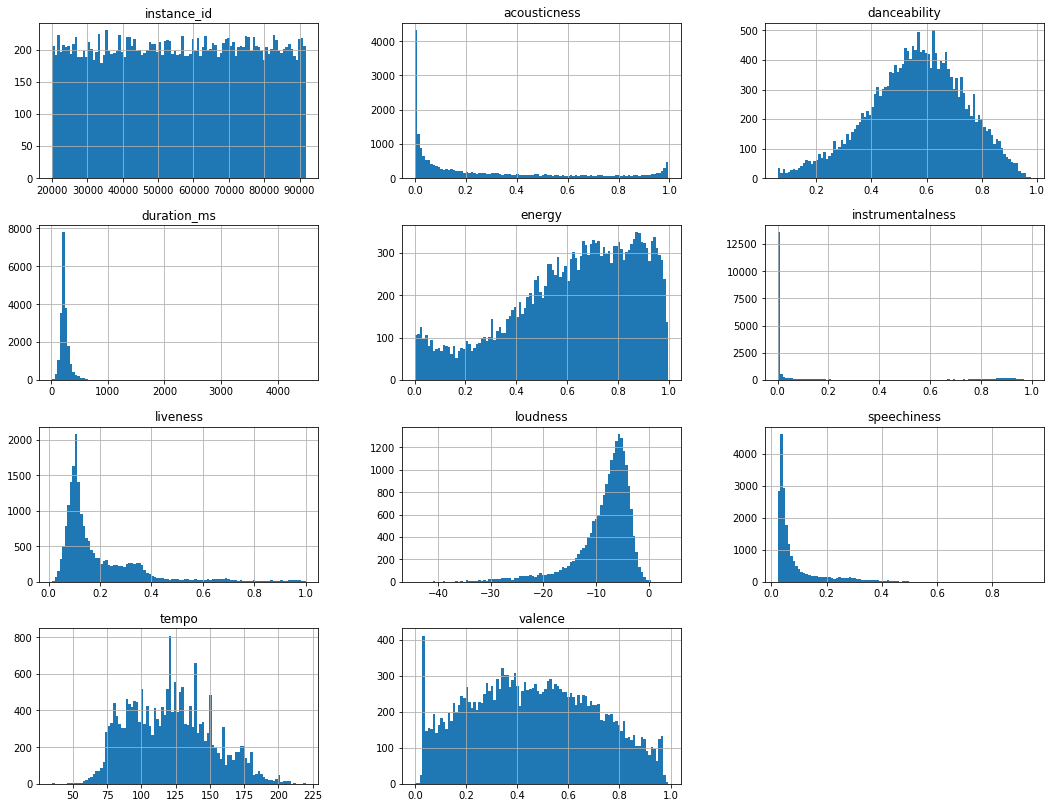

In [48]:
# изучаем столбцы с числовыми данными обучающего набора на графиках
display('Распределение числовых значений в обучающем наборе данных')
train_copy.hist(bins=100,figsize=[18,14]);

In [49]:
# смотрим распределение треков по жанрам
train_copy['music_genre'].value_counts(normalize=True)

Blues          0.140138
Alternative    0.127581
Electronic     0.125521
Rap            0.119046
Rock           0.106195
Country        0.103988
Anime          0.093246
Classical      0.067347
Jazz           0.060774
Hip-Hop        0.056163
Name: music_genre, dtype: float64

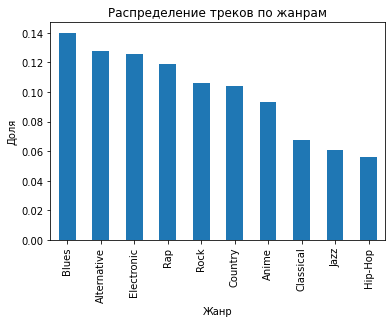

In [50]:
# смотрим распределение треков по жанрам на графике
train_copy['music_genre'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Жанр')
plt.ylabel('Доля')
plt.title('Распределение треков по жанрам')
plt.show() 

In [51]:
# смотрим распределение значений в числовых признаках
train_copy.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000,20387.000000
mean,55977.062491,0.274863,0.561998,241.998647,0.625220,0.160024,0.198519,-8.554052,0.091341,120.928246,0.464612
std,20695.015390,0.321668,0.171909,103.978224,0.251256,0.306546,0.166752,5.500415,0.097726,30.098833,0.243393
min,20011.000000,0.000000,0.060000,15.509000,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38168.000000,0.015200,0.451000,196.090500,0.470000,0.000000,0.097300,-10.258000,0.035600,96.029000,0.272000
50%,56032.000000,0.120000,0.570000,221.378000,0.666000,0.000144,0.130000,-7.053000,0.049000,120.012000,0.457000
75%,73915.500000,0.470500,0.683000,266.000000,0.830000,0.084450,0.252500,-5.054000,0.095400,140.973000,0.653000
max,91758.000000,0.996000,0.978000,4497.994000,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


In [52]:
# смотрим распределение треков с продолжительностью свыше 1200с (20 минут) по жанрам
df_long_duration = train_copy[train_copy['duration_ms']>1200].sort_values(by='duration_ms')
df_long_duration.groupby('music_genre')['duration_ms'].count()

music_genre
Blues          3
Classical     10
Electronic     3
Jazz           1
Name: duration_ms, dtype: int64

In [53]:
# смотрим распределение среднего числовых значений по жанрам
train_copy.groupby('music_genre').mean().round(3)

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
music_genre,,,,,,,,,,,
Alternative,55889.054,0.167,0.547,231.616,0.710,0.062,0.198,-6.561,0.090,122.893,0.449
Anime,55592.122,0.269,0.471,230.035,0.675,0.269,0.195,-7.787,0.065,126.522,0.436
Blues,55960.640,0.314,0.527,249.738,0.614,0.091,0.237,-8.958,0.061,121.332,0.578
Classical,56364.104,0.877,0.304,306.096,0.175,0.597,0.168,-21.596,0.053,103.600,0.208
Country,56271.026,0.275,0.579,217.473,0.636,0.005,0.184,-7.325,0.050,123.153,0.540
Electronic,56490.306,0.121,0.619,265.342,0.738,0.349,0.208,-7.002,0.099,126.301,0.389
Hip-Hop,56077.266,0.182,0.719,216.753,0.645,0.010,0.200,-6.844,0.209,120.437,0.474
Jazz,56268.140,0.500,0.582,263.796,0.472,0.365,0.173,-11.334,0.071,111.599,0.503
Rap,55375.118,0.169,0.700,218.934,0.652,0.008,0.197,-6.650,0.187,119.870,0.457


In [54]:
# создаем цикл для созания сводной таблицы с наиболее частовстречающимися значениями признаков 
# в каждом жанре 
# выбираем колонки
df_columns = ['track_name', 'acousticness', 'danceability',
              'duration_ms', 'energy', 'instrumentalness', 
              'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'valence'
             ]
rows=[]
for i in df_columns:
    # создаем сводную таблицу
    df_join = train_copy.pivot_table(
    index='music_genre',
    columns=i,
    values='instance_id',
    aggfunc=('count'))        
    df_idxmax = df_join.idxmax(axis=1)    
    rows.append(df_idxmax) # формируем список для объеднения 
    
# объединяем таблицы 
df_join_concat = pd.concat(rows, axis=1, keys=['track_name',
                                        'acousticness',
                                        'danceability',
                                        'duration_ms',
                                        'energy',
                                        'instrumentalness',
                                        'key',
                                        'liveness',
                                        'loudness',
                                        'mode',       
                                        'speechiness',
                                        'tempo',
                                        'valence']
                          )
# выводим итоговую таблицу
df_join_concat    

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
music_genre,,,,,,,,,,,,,
Alternative,Blue,0.00105,0.529,217.600,0.859,0.0,D,0.110,-4.159,Major,0.0332,119.9995,0.4240
Anime,Boys & Girls,0.99000,0.435,217.600,0.947,0.0,D,0.110,-4.587,Major,0.0332,119.6030,0.3320
Blues,Sweet Home Chicago,0.14400,0.591,217.600,0.613,0.0,D,0.108,-5.016,Major,0.0336,120.0750,0.3380
Classical,I. Allegro,0.99500,0.388,217.600,0.104,0.0,D,0.103,-14.916,Major,0.0384,119.9450,0.0368
Country,In My Head,0.10800,0.554,222.267,0.722,0.0,D,0.110,-8.669,Major,0.0297,119.9450,0.3620
Electronic,On My Own,0.14900,0.555,217.600,0.938,0.0,C#,0.101,-9.759,Major,0.0398,121.1370,0.1350
Hip-Hop,Blessings,0.19400,0.758,215.440,0.557,0.0,C#,0.107,-6.711,Major,0.1650,116.1825,0.3240
Jazz,Afro Blue,0.83500,0.532,217.600,0.471,0.0,D,0.108,-9.150,Major,0.0329,120.0750,0.9610
Rap,Save Me,0.12900,0.856,215.440,0.579,0.0,C#,0.111,-6.442,Major,0.2710,123.9680,0.5840


In [55]:
# создаем цикл для созания сводной таблицы с наиболее редковстречающимися значениями 
# признаков в каждом жанре 
# выбираем колонки
df_columns = ['track_name', 'acousticness', 'danceability',
              'duration_ms', 'energy', 'instrumentalness', 
              'key', 'liveness', 'loudness', 'mode', 
              'speechiness', 'tempo', 'valence'
             ]
rows=[]
for i in df_columns:
    # создаем сводную таблицу
    df_join = train_copy.pivot_table(
    index='music_genre',
    columns=i,
    values='instance_id',
    aggfunc=('count'))        
    df_idxmax = df_join.idxmin(axis=1)    
    rows.append(df_idxmax) # формируем список для объеднения 
    
# объединяем таблицы 
df_join_concat = pd.concat(rows, axis=1, keys=['track_name',
                                        'acousticness',
                                        'danceability',
                                        'duration_ms',
                                        'energy',
                                        'instrumentalness',
                                        'key',
                                        'liveness',
                                        'loudness',
                                        'mode',
                                        'speechiness',
                                        'tempo',
                                        'valence']
                          )
# выводим итоговую таблицу
df_join_concat

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
music_genre,,,,,,,,,,,,,
Alternative,"""99""",0.000001,0.1030,34.750,0.05560,0.000001,D#,0.0212,-20.741,Minor,0.0233,51.316,0.0342
Anime,"""DEVILS NEVER CRY""(スタッフロール)",0.000000,0.0606,30.027,0.00243,0.000001,D#,0.0169,-38.833,Minor,0.0229,47.704,0.0252
Blues,$20 Fine,0.000002,0.1180,30.097,0.00957,0.000001,D#,0.0136,-30.800,Minor,0.0231,47.587,0.0315
Classical,"""Christen, ätzet diesen Tag"", BWV 63: I. Chora...",0.000005,0.0600,15.509,0.00101,0.000001,F#,0.0365,-44.406,Minor,0.0244,34.856,0.0000
Country,$50 Dollars and a Flask of Crown,0.000108,0.2030,92.400,0.04270,0.000001,D#,0.0212,-27.119,Minor,0.0223,58.095,0.0594
Electronic,#15,0.000003,0.0822,34.459,0.02110,0.000001,D#,0.0194,-24.798,Minor,0.0234,54.951,0.0276
Hip-Hop,(562) 453-9382 - Skit,0.000087,0.2840,33.093,0.19600,0.000001,D#,0.0278,-25.602,Minor,0.0260,47.917,0.0375
Jazz,"""It’s A Good Day""",0.000008,0.0644,50.385,0.01410,0.000001,D#,0.0310,-29.709,Minor,0.0230,34.765,0.0289
Rap,$ave Dat Money (feat. Fetty Wap & Rich Homie Q...,0.000007,0.1970,59.118,0.07930,0.000001,D#,0.0241,-22.589,Minor,0.0229,47.811,0.0336


In [56]:
# создаем функцию построения графиков распределения числовых признаков по жанрам 
def plotly_num(data, values, ylim, ylabel, title):
    (data
    .pivot_table(index='music_genre', 
                 values=values
                 #aggfunc='mean'
                ).plot(
        kind='bar',
        xlim=(0,27), 
        ylim=(ylim), 
        grid=True,
        legend=False))

    plt.xlabel('Жанр')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show() 

'Распределение усредненных числовых характеристик треков по жанрам'

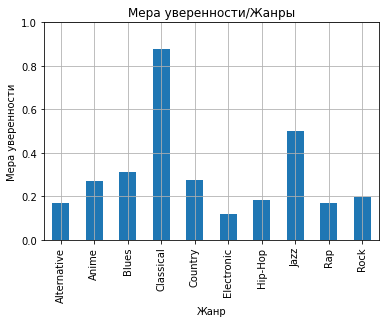

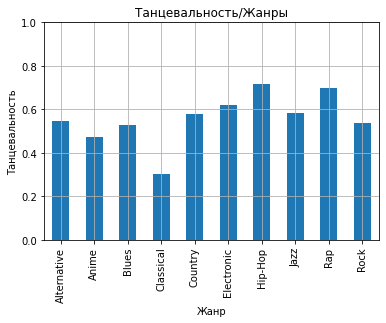

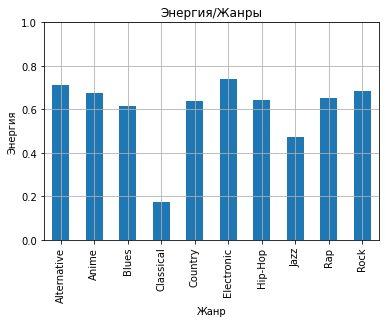

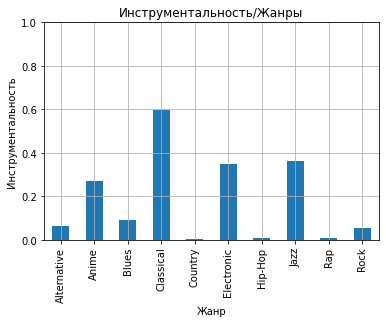

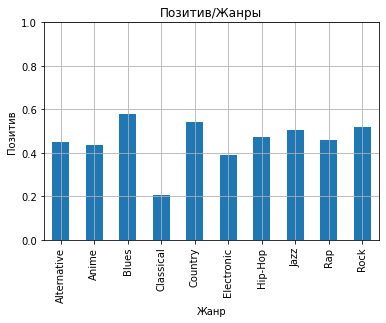

In [57]:
# строим графики распределения числовых характеристик треков по жанрам
display('Распределение усредненных числовых характеристик треков по жанрам')
plotly_num(train_copy,    
       'acousticness',(0,1),      
       'Мера уверенности',    
       'Мера уверенности/Жанры'
          )
plotly_num(train_copy,    
       'danceability',(0,1),      
       'Танцевальность',    
       'Танцевальность/Жанры'
          )
plotly_num(train_copy,    
       'energy',(0,1),       
       'Энергия',    
       'Энергия/Жанры'
          )
plotly_num(train_copy,    
       'instrumentalness',(0,1),      
       'Инструментальность',    
       'Инструментальность/Жанры'
          )
plotly_num(train_copy,    
       'valence',(0, 1),
       'Позитив',    
       'Позитив/Жанры')

'Распределение усредненных числовых характеристик треков по жанрам'

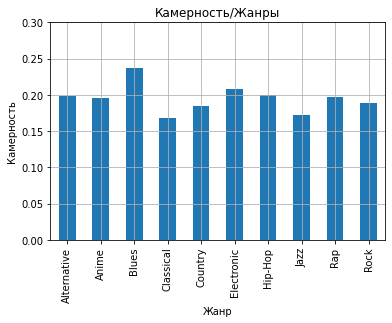

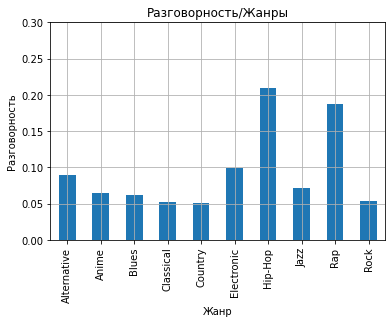

In [58]:
# строим графики распределения числовых характеристик треков по жанрам
display('Распределение усредненных числовых характеристик треков по жанрам')
plotly_num(train_copy,    
       'liveness',(0,0.3),    
       'Камерность',    
       'Камерность/Жанры'
          )
plotly_num(train_copy,    
       'speechiness',(0,0.3),
       'Разговорность',    
       'Разговорность/Жанры')

'Распределение усредненных числовых характеристик треков по жанрам'

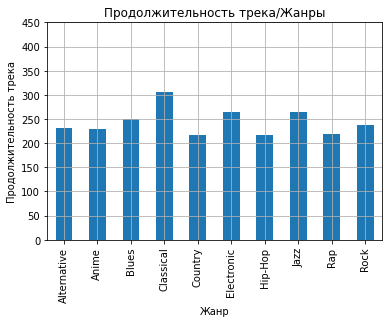

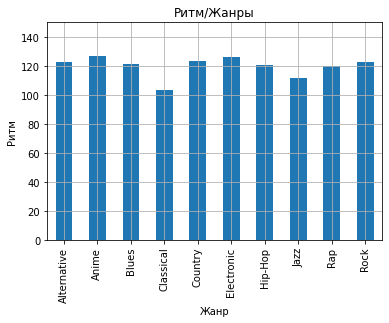

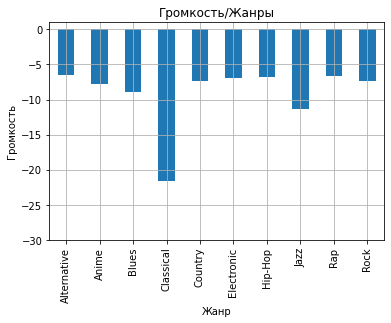

In [59]:
# строим графики распределения числовых характеристик треков по жанрам
display('Распределение усредненных числовых характеристик треков по жанрам')
plotly_num(train_copy,    
       'duration_ms',(0,450),      
       'Продолжительность трека',    
       'Продолжительность трека/Жанры'
          )
plotly_num(train_copy,    
       'tempo',(0,150),      
       'Ритм',    
       'Ритм/Жанры'
          )
plotly_num(train_copy,    
       'loudness',(-30,1),       
       'Громкость',    
       'Громкость/Жанры')

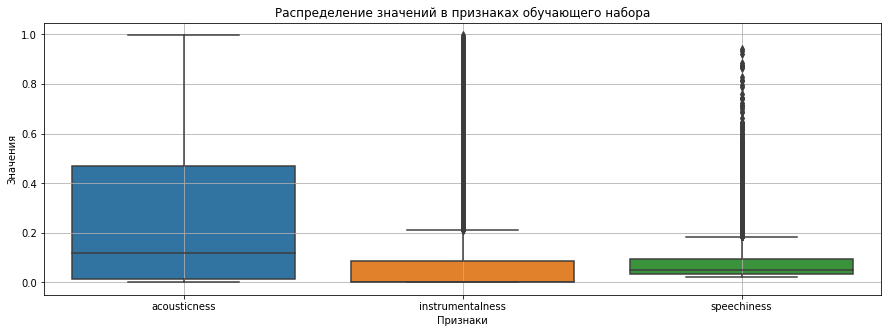

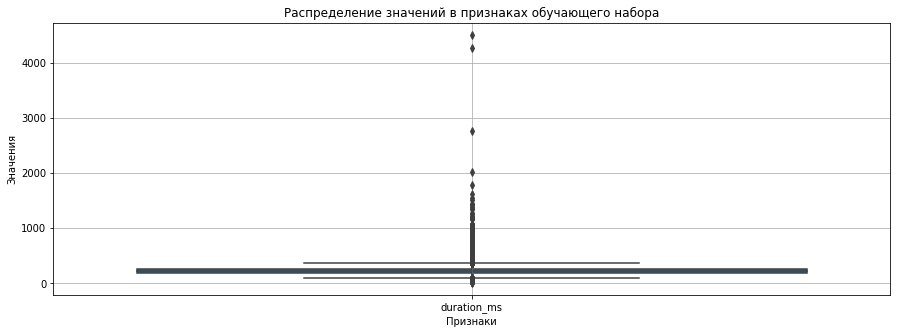

In [60]:
# создаем функцию для построения диаграмм разброса для признаков с выбросами
def boxplotly(data, xlabel, ylabel, title):
    
    plt.figure(figsize=(15, 5))    
    sns.boxplot(data=data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.title(title)
    plt.show()   

# смотрим разброс в признаках с выбросами в тренировочном наборе     
columns = ['acousticness','instrumentalness','speechiness']
boxplotly(train_copy[columns], 'Признаки', 'Значения', 'Распределение значений в признаках обучающего набора')
columns = ['duration_ms']
boxplotly(train_copy[columns], 'Признаки', 'Значения', 'Распределение значений в признаках обучающего набора')

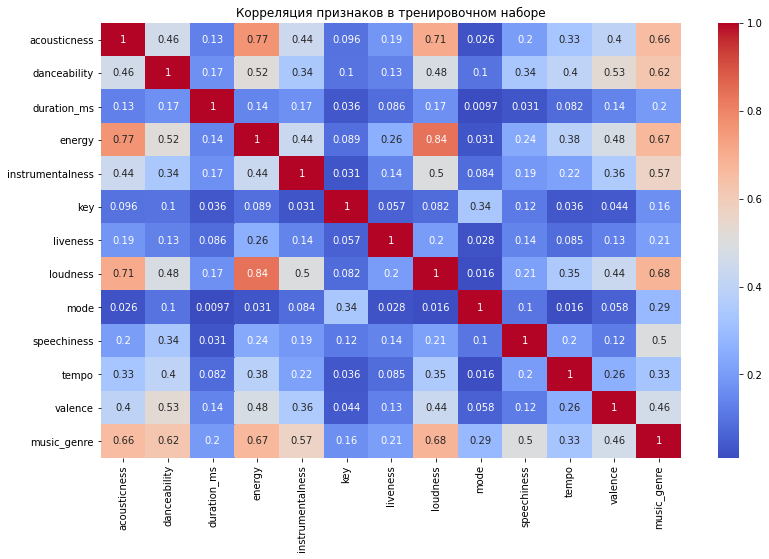

In [61]:
# строим тепловую карту корреляции с выбранными колонками
# вычисляем матрицу корреляции с использованием Phi_K
corr_matrix = train_copy[dup_col].phik_matrix(train_copy[dup_col].select_dtypes(exclude='object'))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в тренировочном наборе')
plt.show() 

## Тестовый набор

'Распределение числовых значений в обучающем наборе данных'

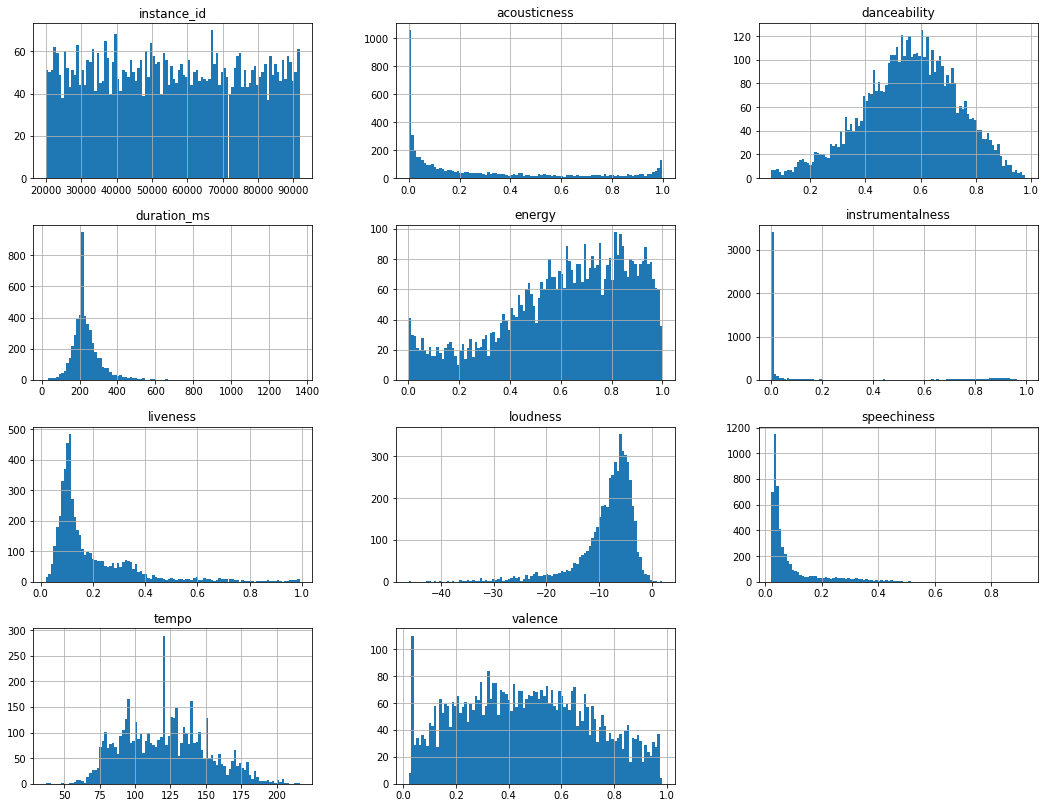

In [62]:
# изучаем столбцы с числовыми данными тестового набора на графиках
display('Распределение числовых значений в обучающем наборе данных')
df_test.hist(bins=100,figsize=[18,14]);

In [63]:
# смотрим распределение значений в числовых признаках
df_test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000
mean,55643.871347,0.276324,0.561888,239.307514,0.622030,0.165198,0.197924,-8.630186,0.092718,121.223860,0.465593
std,20762.384803,0.322657,0.170502,90.410039,0.251829,0.311940,0.166241,5.619766,0.100130,29.520696,0.244217
min,20012.000000,0.000002,0.059600,22.750000,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,194.428500,0.465000,0.000000,0.096950,-10.231000,0.035700,96.732500,0.272000
50%,55246.000000,0.120000,0.568000,221.027000,0.660000,0.000157,0.129000,-7.135000,0.048700,120.039000,0.458000
75%,73702.000000,0.460000,0.681000,264.247000,0.826000,0.092750,0.248000,-5.127000,0.096550,141.002500,0.650000
max,91709.000000,0.996000,0.977000,1360.027000,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


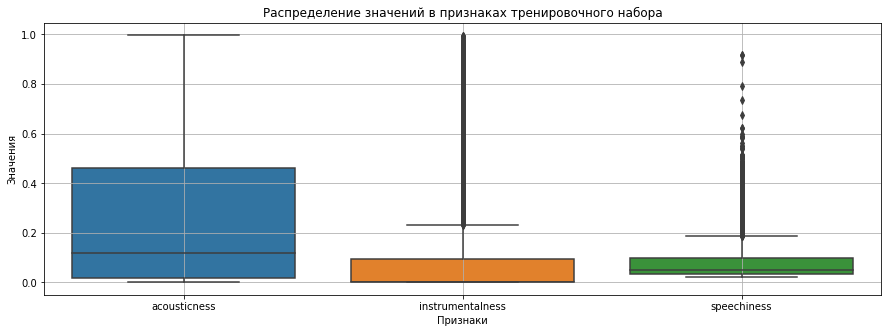

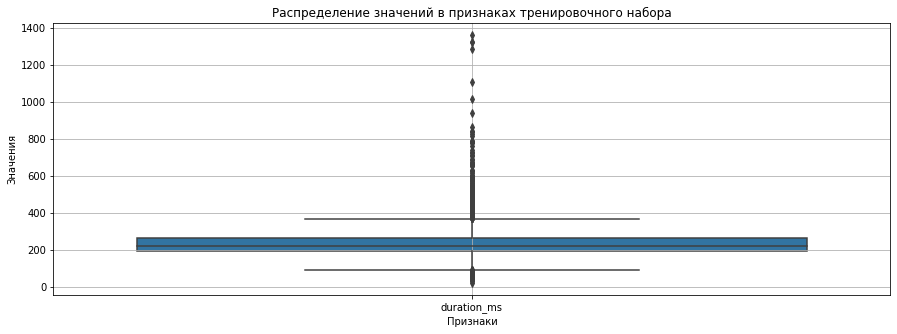

In [64]:
# смотрим разброс в признаках с выбросами в тестовом наборе    
columns = ['acousticness','instrumentalness','speechiness']
boxplotly(df_test[columns], 'Признаки', 'Значения', 'Распределение значений в признаках тренировочного набора')
columns = ['duration_ms']
boxplotly(df_test[columns], 'Признаки', 'Значения', 'Распределение значений в признаках тренировочного набора')

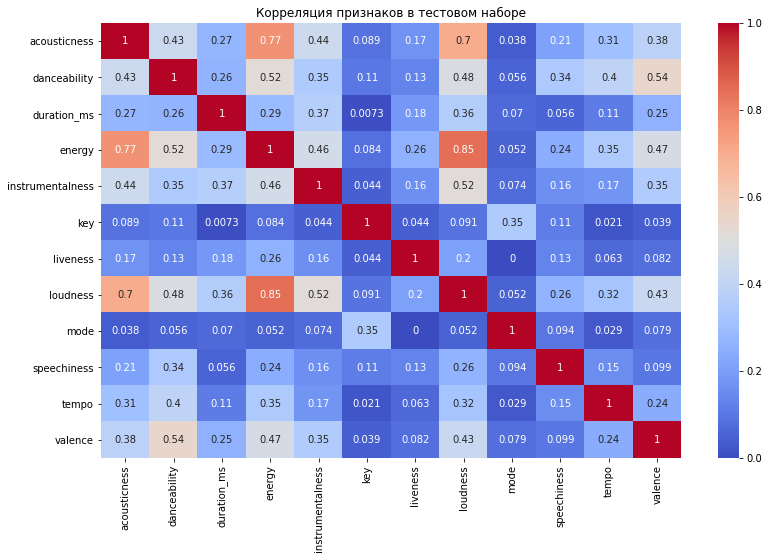

In [65]:
# строим тепловую диаграмму признаков тестового набора с выбранными колонками
# вычисляем матрицу корреляции с использованием Phi_K
test_col=df_test.columns[2:]# выбираем колонки

corr_matrix = df_test[test_col].phik_matrix(df_test[test_col].select_dtypes(exclude='object'))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в тестовом наборе')
plt.show()

## Вывод


- Данные, в основном распределены неравномерно, но в некоторых столбцах ('instrumentalness', 'speechiness', 'duration_ms') присутствуют выбросы. 


- В тестовом и тренировочном наборах схожие особенности и распределение признаков.
 
 
 
- В столбце 'instrumentalness' большое количество нулевых значений, что свидетельствует о том, что много треков содержат вокал.
 
 
 
- Треки по  жанрам распределены неравномерно. Больше всего треков в жанре 'Blues', меньше всего в стиле 'Hip-Hop'. Но, в целом, дисбаланс не критический. 
 
 
 
- В основном, признаки одного масштаба, за исключением значений в столбцах 'duration_ms', 'loudness', 'tempo', кторые имеют больший масштаб;
 
  
  
- Изучили максимумы и минимумы в распределении значений по жанрам:

    -  Обращают на себя внимание повторяющиеся значения в колонках с базовой нотой и модельностью ('key' и 'mode'); 
  
    - Остальные значения распределниы по жанрам плотными перекрывающимися диапазонами, что отразится на работе моделей. Особенно, значения в столбцах 'liveness' и 'tempo';
  
  
  
- Наибольший разброс значений по жанрам демонстрируют признаки: 'acousticness', 'instrumentalness', 'speechiness', 'energy' и 'valence'. 



- Наибольшим и внушительным стандартным отклонением обладают значения в столбцах и 'duration_ms' и 'tempo'. Наименьшим - 'danceability'.


  
- Наибольшую корреляцию с целевой переменной ('music_genre') показывают: 'acousticness', 'danceability', 'energy', 'instrumentalness' и 'loudness'.   




- Наименьшая корреляция с целевой переменной ('music_genre') у признаков: 'key', 'liveness' и 'duration_ms'.


- Наибольшую взаимную корреляцию демонстрирует признаки: 'loudness' и 'energy', а каждый из них - с 'acousticness'.



# Разработка признаков

## Разделение на выборки

In [66]:
# формируем выборки и выделяем цель и признаки: 
# выделяем цель и признаки
target = df_train['music_genre']
features = df_train.drop('music_genre', axis=1)

# кодируем цель
labelencoder = LabelEncoder()
target = labelencoder.fit_transform(target)

# обратное преобразование 
# target = labelencoder.inverse_transform(target)

# формируем выборки: обучающую(75%) и валидационную(25%)
features_train, features_valid, target_train, target_valid  = train_test_split(features,
                                target,
                                test_size=0.25,
                                random_state=12345,
                                stratify=target) # сохраним исходное соотношение классов
# проверяем
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(15290, 14)
(15290,)
(5097, 14)
(5097,)


## Пропуски и аномалии в выборках

In [67]:
# смотрим пропуски
print(features_train.isna().sum())
print()
print(features_valid.isna().sum())
print()
df_test.isna().sum() 

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 566
liveness              0
loudness              0
mode                384
speechiness           0
tempo               338
valence               0
dtype: int64

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 168
liveness              0
loudness              0
mode                122
speechiness           0
tempo               104
valence               0
dtype: int64



instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64

In [68]:
# смотрим аномалии в столбце duration_ms 
print(features_train['duration_ms'].describe())
print()
print(features_valid['duration_ms'].describe())
print()
df_test['duration_ms'].describe()

count    15290.000000
mean       220.087660
std        120.687588
min         -0.001000
25%        177.671000
50%        219.175000
75%        265.907000
max       2764.934000
Name: duration_ms, dtype: float64

count    5097.000000
mean      221.204993
std       143.402865
min        -0.001000
25%       177.160000
50%       220.808000
75%       266.187000
max      4497.994000
Name: duration_ms, dtype: float64



count    5099.000000
mean      239.307514
std        90.410039
min        22.750000
25%       194.428500
50%       221.027000
75%       264.247000
max      1360.027000
Name: duration_ms, dtype: float64

### Замена пропусков и аномалий в тренировочном наборе

In [69]:
# меняем пропуски в столбце key в тренировочном наборе
# на численное значение медианы столбца acousticness
for d in features_train['key'].unique():
    
    features_train.loc[features_train['key'
                         ].isna(), 'key'
                ] = features_train.loc[features_train['key'] == d, 'acousticness'].median()
# проверяем
print(features_train['key'].isna().sum())
features_train.groupby('key')['acousticness'].median().sort_values()

0


key
C#        0.0722
B         0.0756
F#        0.0997
D         0.1060
G#        0.1105
G         0.1190
0.0722    0.1220
A#        0.1365
E         0.1380
A         0.1430
C         0.1460
F         0.1715
D#        0.2280
Name: acousticness, dtype: float64

In [70]:
# меняем численное значение медианы на соответствующее буквенное 
features_train.loc[features_train['key'] == 0.0722, 'key'] = 'C#' 

# проверяем
print(features_train['key'].isna().sum())
features_train.groupby('key')['acousticness'].median().sort_values()

0


key
B     0.0756
C#    0.0828
F#    0.0997
D     0.1060
G#    0.1105
G     0.1190
A#    0.1365
E     0.1380
A     0.1430
C     0.1460
F     0.1715
D#    0.2280
Name: acousticness, dtype: float64

In [71]:
# проверяем распределение значений в столбце key 
features_train['key'].value_counts(normalize=True)

C#    0.141596
G     0.113865
C     0.103663
D     0.102027
A     0.098169
F     0.079398
B     0.074951
E     0.074951
G#    0.062786
A#    0.060955
F#    0.057619
D#    0.030020
Name: key, dtype: float64

In [72]:
# меняем пропуски в столбце tempo 
# проверяем до
print(features_train['tempo'].isna().sum())
print(features_train['tempo'].describe())
print()

# меняем пропуски в столбце tempo на медиану группы по столбцу key
name = 'tempo'
features_train[name] = np.where(features_train[name].isna(),
                 features_train['key'].map(features_train.groupby('key')[name].median()), 
                 features_train[name])

# проверяем после
print(features_train['tempo'].isna().sum())
print(features_train['tempo'].describe())

338
count    14952.000000
mean       121.018783
std         30.506522
min         34.765000
25%         95.840750
50%        120.012500
75%        141.977750
max        219.331000
Name: tempo, dtype: float64

0
count    15290.000000
mean       121.000892
std         30.168339
min         34.765000
25%         96.017000
50%        120.007000
75%        140.965250
max        219.331000
Name: tempo, dtype: float64


In [73]:
# меняем пропуски в столбце mode
# на численное значение медианы 
for d in features_train['mode'].unique():
    
    features_train.loc[features_train['mode'
                         ].isna(), 'mode'
                ] = features_train.loc[features_train['mode'] == d, 'acousticness'].median()
# проверяем
print(features_train['mode'].isna().sum())
features_train.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.104
0.127    0.115
Major    0.127
Name: acousticness, dtype: float64

In [74]:
# меняем численное значение медианы на соответствующее буквенное 
features_train.loc[features_train['mode'] == 0.127, 'mode'] = 'Major' 

# проверяем
print(features_train['mode'].isna().sum())
features_train.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.104
Major    0.126
Name: acousticness, dtype: float64

In [75]:
# проверяем пропуски
features_train.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64

In [76]:
# меняем аномальное значение в столбце duration_ms
# проверяем до
print(features_train['duration_ms'].describe())
print()

# меняем пропуски в столбце duration_ms на медиану группы по столбцу key
name = 'duration_ms'
features_train[name] = np.where(features_train[name]== -0.001,
                 features_train['key'].map(features_train.groupby('key')[name].median()), 
                 features_train[name])
# проверяем после
print(features_train['duration_ms'].describe())

count    15290.000000
mean       220.087660
std        120.687588
min         -0.001000
25%        177.671000
50%        219.175000
75%        265.907000
max       2764.934000
Name: duration_ms, dtype: float64

count    15290.000000
mean       241.632759
std         96.643299
min         27.179000
25%        196.000000
50%        220.947000
75%        265.907000
max       2764.934000
Name: duration_ms, dtype: float64


### Замена пропусков и аномалий в валидационном наборе

In [77]:
# меняем пропуски в столбце key в тестовом наборе, избегая утечки данных
# на численное значение медианы 
for d in features_valid['key'].unique():
    
    features_valid.loc[features_valid['key'
                         ].isna(), 'key'
                ] = features_train.loc[features_train['key'] == d, 'acousticness'].median()
# проверяем
print(features_valid['key'].isna().sum())
features_valid.groupby('key')['acousticness'].median().sort_values()

0


key
B         0.0818
F#        0.0887
C#        0.0906
A         0.1090
D         0.1180
A#        0.1260
0.1105    0.1270
E         0.1280
G         0.1415
G#        0.1450
F         0.1590
C         0.1760
D#        0.1950
Name: acousticness, dtype: float64

In [78]:
# меняем численое значение медианы на соответствующее буквенное 
features_valid.loc[features_valid['key'] == 0.1105, 'key'] = 'D' 

# проверяем
print(features_valid['key'].isna().sum())
features_valid.groupby('key')['acousticness'].median().sort_values()

0


key
B     0.0818
F#    0.0887
C#    0.0906
A     0.1090
D     0.1230
A#    0.1260
E     0.1280
G     0.1415
G#    0.1450
F     0.1590
C     0.1760
D#    0.1950
Name: acousticness, dtype: float64

In [79]:
# проверяем распределение значений в столбце key 
features_valid['key'].value_counts(normalize=True)

D     0.140671
C     0.110653
G     0.110261
C#    0.103198
A     0.100451
F     0.078674
B     0.073573
E     0.072592
F#    0.063763
G#    0.060232
A#    0.057092
D#    0.028840
Name: key, dtype: float64

In [80]:
# меняем пропуски в столбце tempo, избегая утечки данных

# проверяем до
print(features_valid['tempo'].isna().sum())
print(features_valid['tempo'].describe())
print()

# меняем пропуски в столбце tempo на медиану группы по столбцу key
name = 'tempo'
features_valid[name] = np.where(features_valid[name].isna(),
                 features_valid['key'].map(features_train.groupby('key')[name].median()), 
                 features_valid[name])

# проверяем после
print(features_valid['tempo'].isna().sum())
print(features_valid['tempo'].describe())

104
count    4993.000000
mean      120.720625
std        30.200463
min        46.718000
25%        95.997000
50%       120.013000
75%       141.914000
max       220.041000
Name: tempo, dtype: float64

0
count    5097.000000
mean      120.712986
std        29.891886
min        46.718000
25%        96.100000
50%       120.008000
75%       140.981000
max       220.041000
Name: tempo, dtype: float64


In [81]:
# меняем пропуски в столбце mode
# на численное значение медианы 
for d in features_valid['mode'].unique():
    
    features_valid.loc[features_valid['mode'
                         ].isna(), 'mode'
                ] = features_train.loc[features_train['mode'] == d, 'acousticness'].median()
# проверяем
print(features_valid['mode'].isna().sum())
features_valid.groupby('mode')['acousticness'].median().sort_values()

0


mode
0.104    0.105
Minor    0.118
Major    0.131
Name: acousticness, dtype: float64

In [82]:
# меняем численное значение медианы на соответствующее буквенное 
features_valid.loc[features_valid['mode'] == 0.104, 'mode'] = 'Minor' 

# проверяем
print(features_valid['mode'].isna().sum())
features_valid.groupby('mode')['acousticness'].median().sort_values()

0


mode
Minor    0.117
Major    0.131
Name: acousticness, dtype: float64

In [83]:
# проверяем пропуски
features_valid.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
dtype: int64

In [84]:
# меняем аномальное значение в столбце duration_ms, избегая утечки данных
# проверяем до
print(features_valid['duration_ms'].describe())
print()

# меняем пропуски в столбце duration_ms на медиану группы по столбцу key
name = 'duration_ms'
features_valid[name] = np.where(features_valid[name]== -0.001,
                 features_valid['key'].map(features_train.groupby('key')[name].median()), 
                 features_valid[name])

# проверяем после
print(features_valid['duration_ms'].describe())

count    5097.000000
mean      221.204993
std       143.402865
min        -0.001000
25%       177.160000
50%       220.808000
75%       266.187000
max      4497.994000
Name: duration_ms, dtype: float64

count    5097.000000
mean      242.997180
std       123.415376
min        15.509000
25%       196.600000
50%       221.968000
75%       266.187000
max      4497.994000
Name: duration_ms, dtype: float64


In [85]:
# проверяем размер выборок после замены пропусков и аномалий
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(df_test.shape)

(15290, 14)
(15290,)
(5097, 14)
(5097,)
(5099, 14)


## Добавление новых признаков

In [86]:
# добавляем новый признак в копию обучающего набора
train_copy['track_name_sp'] = (train_copy['track_name'].str.len()/train_copy['speechiness'])

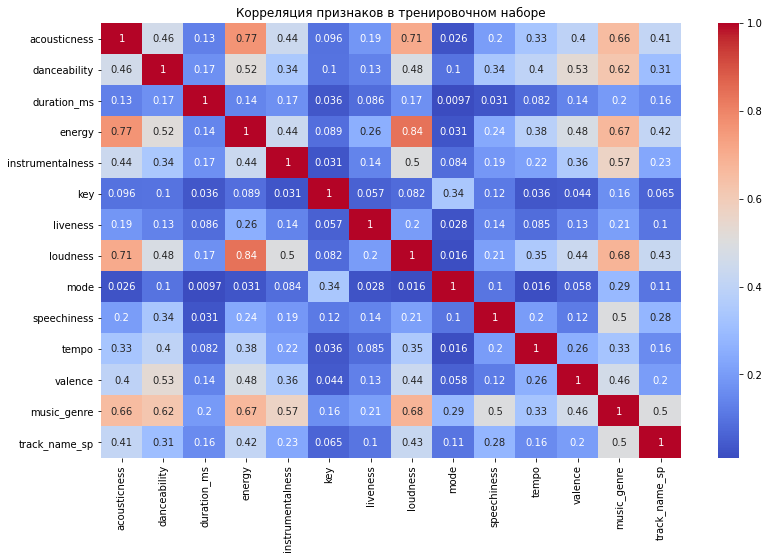

In [87]:
# строим тепловую карту корреляции с выбранными колонками
# вычисляем матрицу корреляции с использованием Phi_K

# выбраем колонки
train_col = train_copy.columns[2:]

# создаем матрицу
corr_matrix = train_copy[train_col].phik_matrix(train_copy[train_col].select_dtypes(exclude='object'))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в тренировочном наборе')
plt.show() 

In [88]:
# группируем данные по жанрам, выбирая средние значения признаков
df_group=train_copy.groupby('music_genre').mean().round(3).sort_values(by='track_name_sp', ascending=False)
df_group['track_name_sp']

music_genre
Classical      1067.730
Country         501.734
Blues           439.726
Rock            433.736
Jazz            383.903
Anime           326.880
Electronic      302.151
Alternative     281.439
Rap             161.084
Hip-Hop         130.787
Name: track_name_sp, dtype: float64

- Новый признак имеет неплохую корреляцию с целевой переменной, и слабую с другими признакам, кроме этого, имеет заметный  разброс по признакам. 

In [89]:
# добавляем новый категориальный признак вместо track_name:
# новый столбец, с длиной названия трека и делим на speechiness, чтобы усилить классовые отличия
features_train['track_name_sp'] = (features_train['track_name'].str.len()/features_train['speechiness']) 
features_valid['track_name_sp'] = (features_valid['track_name'].str.len()/features_valid['speechiness'])

df_test['track_name_sp'] = (df_test['track_name'].str.len()/df_test['speechiness'])

## Вывод


-  Выделили в тренировочном датасете цель и признаки, закодировали цель, разделили на обучающую и валидационную выборки из расчета 75%/25%.

-  Обработали в выборках пропуски и аномалии, заменив на медиану по признакам столбца 'key', избегая утечки данных.


- Добавили новый синтетический признак - 'treck_res' как результат деления длины названия трека на значение столбца 'speechiness', чтобы усилить классовые отличия признаков и повысить обучаемость моделей.

# Проверка на мультиколлинеарность

## Тренировочный набор

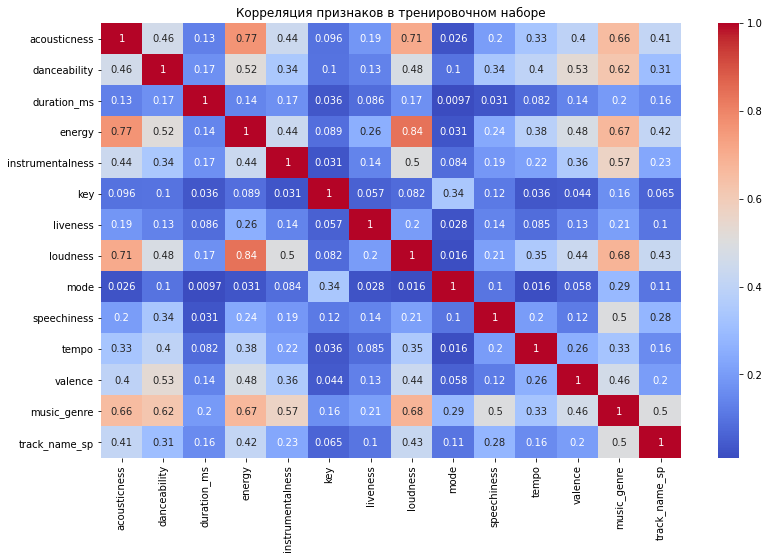

In [90]:
# строим тепловую карту корреляции признаков тренировочного набора с выбранными колонками
# вычисляем матрицу корреляции с использованием Phi_K
# выбираем колонки 
tr_col= train_copy.columns[2:]
corr_matrix = train_copy[tr_col].phik_matrix(train_copy[tr_col].select_dtypes(exclude='object'))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в тренировочном наборе')
plt.show()

## Тестовый набор

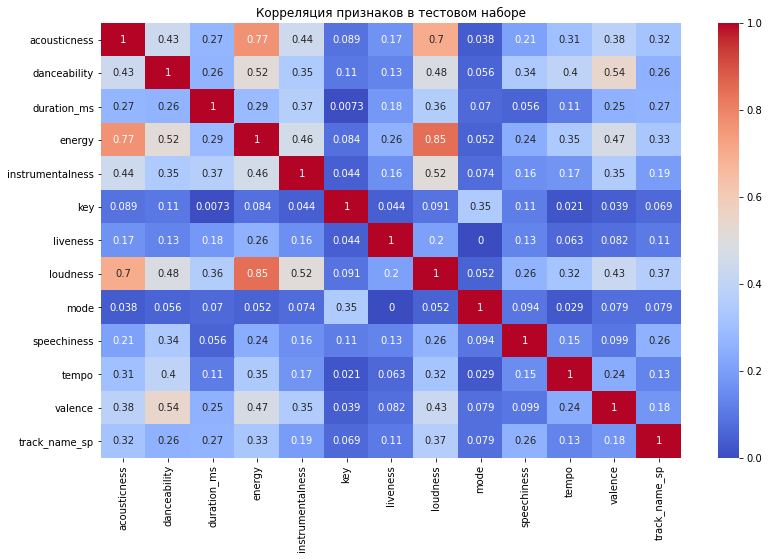

In [91]:
# строим тепловую диаграмму признаков тестового набора с выбранными колонками
# вычисляем матрицу корреляции с использованием Phi_K
# выбираем колонки
test_col = df_test.columns[2:]
corr_matrix = df_test[test_col].phik_matrix(df_test[test_col].select_dtypes(exclude='object'))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в тестовом наборе')
plt.show()

## Вывод

-  В обучающем и тестовом наборах наблюдается сходная взаимная корреляция признаков.


- Наибольшую корреляцию с целевой переменной ('music_genre') в обучающем наборе  показывают: 'acousticness'(0.66), 'danceability'(0.62), 'energy'(0.67), 'loudness'(0.68) и 'instrumentalness'(0.57)    


- Наименьшая корреляция с целевой переменной ('music_genre') у признаков в обучающем наборе: 'key'(0.16), 'liveness'(0.21) и 'duration_ms'(0.20).


- Наибольшую взаимную корреляцию в обучающем наборе демонстрирует признаки: 'loudness' и 'energy' (0.84), а каждый из них - с 'acousticness'(0.71 и 0.77 соответственно). В тестовом наборе ситуация аналогичная.


-  Чтобы нивелировать взамную корреляцию, на следующих шагах удалим некоторые признаки, отмасштабируем выборки и выберем для обучения нелинейные модели, наименее чувствительные к мультиколлинеарности. 


# Отбор признаков для обучения 

## Удаление лишних признаков 

In [92]:
# удаляем неинформативные столбцы с id и track_name во всех наборах
features_train.drop(['instance_id', 'track_name'],axis=1, inplace=True)
features_valid.drop(['instance_id', 'track_name'],axis=1, inplace=True)

df_test.drop(['instance_id', 'track_name'], axis=1, inplace=True)

In [93]:
# удаляем столбцы key и liveness, обладающие малой информаивностью и низкой корреляцией к целевой переменной, 
# во всех наборах 
features_train.drop(['key', 'liveness'],axis=1, inplace=True)
features_valid.drop(['key', 'liveness'],axis=1, inplace=True)

df_test.drop(['key', 'liveness'], axis=1, inplace=True)

## Кодировка категориальных  признаков

In [94]:
# кодируем категориальные признаки и масштабируем численные:

# задаем категориальные признаки для OHE
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

# задаем численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [95]:
# активируем кодировщик категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# кодируем категориальные признаки
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем лишние колонки 
features_train = features_train.drop(ohe_features, axis=1)

# проверяем
print(features_train.shape)

(15290, 11)


In [96]:
# кодируем категориальные признаки в валидационой выборке, кодировщиком, обученным на тернировочной
# кодируем категориальные признаки
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

# удаляем лишние колонки 
features_valid = features_valid.drop(ohe_features, axis=1)

# проверяем
print(features_valid.shape)

(5097, 11)


In [97]:
# кодируем категориальные признаки в тестовом наборе, кодировщиком, обученным на тернировочной
# кодируем категориальные признаки
df_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(df_test[ohe_features])

# удаляем лишние колонки 
df_test = df_test.drop(ohe_features, axis=1)

# проверяем
print(df_test.shape)

(5099, 11)


## Масштабирование числовых признаков

In [98]:
# масштабируем численные признаки 
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
df_test[num_features] = scaler.transform(df_test[num_features])

# проверяем размер итоговых выборок
print(features_train.shape) 
print(features_valid.shape)
print(df_test.shape)

(15290, 11)
(5097, 11)
(5099, 11)


##  Вывод


- Удалили лишние, малоинформативные и обладающие малой корреляцией к целевой переменной признаки: instance_id', 'track_name', 'key' и 'liveness'.

- Закодировали категориальные признаки и провели масштабирование числовых признаков.

- Выборки готовы к обучению. 

#  Выбор и обучение моделей

F1 'Случайного леса' на валидационной выборке: 0.42083578575632724
Матрица ошибок


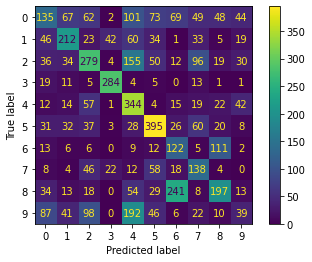

In [99]:
# активируем модель Случайного леса
model_RFC = RandomForestClassifier(random_state=12345,
                               n_estimators=70,
                               max_depth=9,
                               criterion='gini',
                               class_weight='balanced'
                              )
# обучаем модель на тренировочной выборке
model_RFC.fit(features_train, target_train)

# получаем предсказания модели на валидационной выборке
predicted_valid = model_RFC.predict(features_valid)

# считаем значение F1-меры на валидационной выборке 
f1_valid_RFC = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Случайного леса' на валидационной выборке:", f1_valid_RFC)

# строим матрицу ошибок
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_RFC, features_valid, target_valid)
plt.show()

F1 'Машины опорных векторов' на валидационной выборке: 0.4600745536590151
Матрица ошибок


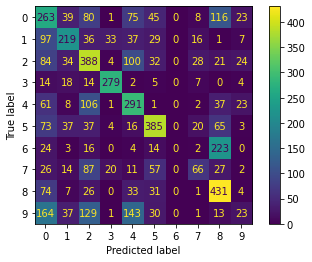

In [100]:
# активируем модель Опорных векторов
model_SVC = svm.SVC(decision_function_shape="ovo", random_state=12345, C=1.5)

# обучаем модель на тренировочной выборке
model_SVC.fit(features_train, target_train)

# получаем предсказания модели на валидационной выборке
predicted_valid = model_SVC.predict(features_valid)

# считаем значение F1-меры на валидационной выборке 
f1_valid_SVC = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Машины опорных векторов' на валидационной выборке:",f1_valid_SVC)

# строим матрицу ошибок
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_SVC, features_valid, target_valid)
plt.show()

F1 'Градиентного бустинга' на валидационной выборке: 0.4534039631155582
Матрица ошибок


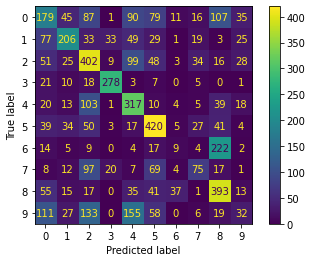

In [101]:
# активируем модель Градиентного бустинга
model_XGBC = xgboost.XGBClassifier(random_state=12345,
                              booster='dart',
                              max_depth=6,
                              subsample=1,                              
                              learning_rate=.3,
                              gamma=0,
                              use_label_encoder=False,
                              n_estimators=9
                             )
# обучаем модель на тренировочной выборке
model_XGBC.fit(features_train, target_train, eval_metric='error')

# предсказываем на валидационной выборке 
predicted_valid = model_XGBC.predict(features_valid)
# рассчитываем F1-меру на валидационной выборке
f1_valid_XGBC = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Градиентного бустинга' на валидационной выборке:", f1_valid_XGBC)

# строим матрицу ошибок
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_XGBC, features_valid, target_valid)
plt.show()

F1 'CatBoost' на валидационной выборке: 0.48047871296841277
Матрица ошибок


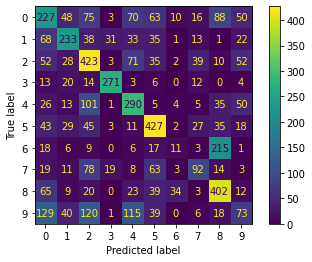

In [102]:
# активируем модель CatBoost
model_CatBoost = CatBoostClassifier(random_state=12345, iterations=2000, learning_rate=0.03)
# обучаем модель на тренировочной выборке
model_CatBoost.fit(features_train, target_train, verbose=False)

# получаем предсказания модели на валидационной выборке
predicted_valid = model_CatBoost.predict(features_valid)

# считаем значение F1-меры на валидационной выборке 
f1_valid_CB = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'CatBoost' на валидационной выборке:",f1_valid_CB)

# строим матрицу ошибок
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_CatBoost, features_valid, target_valid)
plt.show()

In [103]:
# создаем таблицу с результатами работы моделей
df={'model' : ['RForest',  
               'SVC',
               'XGB',
               'CatBoost'],
 'f1_score': [f1_valid_RFC,  
              f1_valid_SVC,
              f1_valid_XGBC,
              f1_valid_CB]}
# выводим результаты
pd.DataFrame(df).sort_values(by='f1_score', ascending=False) 

,model,f1_score
3,CatBoost,0.480479
1,SVC,0.460075
2,XGB,0.453404
0,RForest,0.420836


## Подбор гиперпараметров

In [104]:
%%time
# подбираем гиперпараметры для Случайного леса
# методом HalvingGridSearchCV

# активируем модель
model_RFC_Hgrid = RandomForestClassifier(random_state=12345,
                               class_weight='balanced')

# задаем область поиска гиперпараметров
parametrs = {'n_estimators': range(10, 91, 10),
             'criterion': ['gini', 'entropy'],
             'max_depth': range (1, 21, 3)
            }
# запускаем поиск и обучение
Hgrid = HalvingGridSearchCV(model_RFC_Hgrid, parametrs, cv=10, n_jobs=-1, verbose=False, 
                            factor=2, min_resources='exhaust',
                            scoring='f1_micro')
Hgrid.fit(features_train, target_train)

# выводим найденные гиперпараметры
best_max_depth = Hgrid.best_params_.get('max_depth')
best_n_estimators = Hgrid.best_params_.get('n_estimators')
best_criterion =  Hgrid.best_params_.get('criterion')
display(Hgrid.best_params_)

{'criterion': 'gini', 'max_depth': 19, 'n_estimators': 90}

CPU times: user 12.6 s, sys: 1.2 s, total: 13.8 s
Wall time: 5min 20s


F1 'Случайного леса' на валидационной выборке: 0.4541887384736119
Матрица ошибок


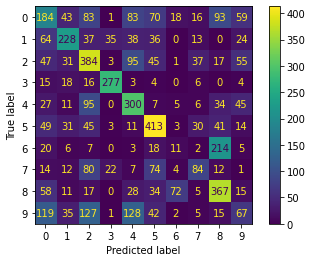

In [105]:
# запускаем модель Случайного леса с подобранными гиперпараметрами
model_RFC_Hgrid = RandomForestClassifier(random_state=12345,
                               n_estimators=best_n_estimators,
                               max_depth=best_max_depth,
                               criterion=best_criterion,
                               class_weight='balanced')
# обучаем модель на тренировочной выборке
model_RFC_Hgrid.fit(features_train, target_train)

# получаем предсказания модели на валидационной выборке
predicted_valid = model_RFC_Hgrid.predict(features_valid)


# считаем значение F1-меры на валидационной выборке 
f1_valid_RFC_selection = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Случайного леса' на валидационной выборке:", f1_valid_RFC_selection)
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_RFC_Hgrid, features_valid, target_valid)
plt.show()

In [106]:
%%time
# подбираем гиперпараметры для Опорных векторов  
# методом HalvingGridSearchCV

# активируем модель
model_SVC_Hgrid = svm.SVC(decision_function_shape="ovo")

# задаем область поиска гиперпараметров
parametrs = {'C': [0.5, 1.0, 1.5]}

# запускаем поиск и обучение
Hgrid = HalvingGridSearchCV(model_SVC_Hgrid, parametrs, cv=10, n_jobs=-1, verbose=False, 
                            factor=2, min_resources='exhaust',
                            scoring='f1_micro')
Hgrid.fit(features_train, target_train)

# выводим найденные гиперпараметры
best_C = Hgrid.best_params_.get('C')
display(Hgrid.best_params_)

{'C': 1.5}

CPU times: user 11.6 s, sys: 113 ms, total: 11.7 s
Wall time: 8min 28s


F1 'Машины опорных векторов' на валидационной выборке: 0.4600745536590151
Матрица ошибок


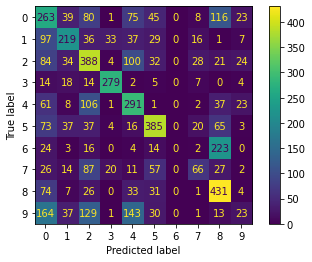

In [107]:
# запускаем модель Опорных векторов с подобранными гиперпараметрами
model_SVC_Hgrid = svm.SVC(decision_function_shape="ovo", random_state=12345, C=best_C)

# обучаем модель на тренировочной выборке
model_SVC_Hgrid.fit(features_train, target_train)

# получаем предсказания модели на валидационной выборке
predicted_valid = model_SVC_Hgrid.predict(features_valid)

# считаем значение F1-меры на валидационной выборке 
f1_valid_SVC_selection = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Машины опорных векторов' на валидационной выборке:",f1_valid_SVC_selection)
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_SVC_Hgrid, features_valid, target_valid)
plt.show()

In [108]:
%%time
# подбираем гиперпараметры для Градиентного бустинга 
# методом HalvingGridSearchCV

# активируем модель
model_XGBC_Hgrid = xgboost.XGBClassifier(random_state=12345,
                                   booster='dart',
                                   subsample=1,                              
                                   learning_rate=.3,
                                   gamma=0,
                                   use_label_encoder=False
                                  )
# задаем область поиска гиперпараметров
parametrs = {'max_depth': range(1, 15, 3),
             'n_estimators': range(1, 12, 3)             
            }
# запускаем поиск и обучение
Hgrid = HalvingGridSearchCV(model_XGBC_Hgrid, parametrs, cv=10, n_jobs=-1, verbose=False, 
                            factor=2, min_resources='exhaust',
                            scoring='f1_micro')
Hgrid.fit(features_train, target_train, eval_metric='error')

# выводим найденные гиперпараметры
best_max_depth_XGBС = Hgrid.best_params_.get('max_depth')
best_n_estimators_XGBС = Hgrid.best_params_.get('n_estimators')
display(Hgrid.best_params_)

{'max_depth': 7, 'n_estimators': 10}

CPU times: user 11.3 s, sys: 215 ms, total: 11.5 s
Wall time: 2min 37s


F1 'Градиентного бустинга' на валидационной выборке: 0.4530115754365313
Матрица ошибок


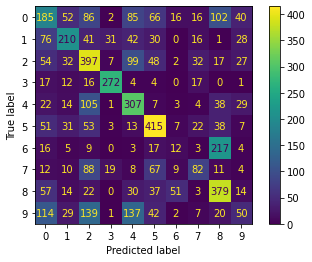

In [109]:
# запускаем модель Градиентного бустинга с подобранными гиперпараметрами
model_XGBC_Hgrid = xgboost.XGBClassifier(random_state=12345,
                                   booster='dart',
                                   max_depth=best_max_depth_XGBС,
                                   subsample=1,                              
                                   learning_rate=.3,
                                   gamma=0,
                                   use_label_encoder=False,
                                   n_estimators=best_n_estimators_XGBС
                                  )
# обучаем модель на тренировочной выборке
model_XGBC_Hgrid.fit(features_train, target_train, eval_metric='error')

# предсказываем на валидационной выборке 
predicted_valid = model_XGBC_Hgrid.predict(features_valid)

# рассчитываем F1-меру на валидационной выборке
f1_valid_XGBC_selection = f1_score(target_valid, predicted_valid, average='micro')

# выводим результаты
print("F1 'Градиентного бустинга' на валидационной выборке:", f1_valid_XGBC_selection)
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_XGBC_Hgrid, features_valid, target_valid)
plt.show()

In [110]:
%%time
# подбираем гиперпараметры для CatBoost
# методом HalvingGridSearchCV

# активируем модель
model_CatBoost_Hgrid = CatBoostClassifier(random_state=12345)

# задаем область поиска гиперпараметров
parametrs = {'iterations': [1000, 2000],
             'depth':[2,3,5]                   
            }
# запускаем поиск и обучение
Hgrid = HalvingGridSearchCV(model_CatBoost_Hgrid, parametrs, cv=10, n_jobs=-1, verbose=1, 
                            factor=2, min_resources='exhaust',
                            scoring='f1_micro')
Hgrid.fit(features_train, target_train, verbose=False)

# выводим найденные гиперпараметры
best_iterations_СB = Hgrid.best_params_.get('iterations')
best_depth_СB = Hgrid.best_params_.get('depth')
display(Hgrid.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 3822
max_resources_: 15290
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 6
n_resources: 3822
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 3
n_resources: 7644
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 15288
Fitting 10 folds for each of 2 candidates, totalling 20 fits


{'depth': 3, 'iterations': 2000}

CPU times: user 1min 2s, sys: 2.23 s, total: 1min 5s
Wall time: 13min 12s


F1 'CatBoost' на валидационной выборке: 0.47341573474592896
Матрица ошибок


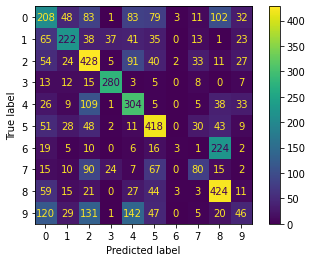

In [111]:
# запускаем модель активируем модель CatBoost с подобранными гиперпараметрами
model_CatBoost_Hgrid = CatBoostClassifier(random_state=12345,
                                    iterations=best_iterations_СB,
                                    depth=best_depth_СB,
                                    learning_rate=0.03)

# обучаем модель на тренировочной выборке
model_CatBoost_Hgrid.fit(features_train, target_train, verbose=False)
         
# получаем предсказания модели на валидационной выборке
predicted_valid = model_CatBoost_Hgrid.predict(features_valid)

# считаем значение F1-меры на валидационной выборке 
f1_valid_CB_selection = f1_score(target_valid, predicted_valid, average='micro')

# получаем предсказание модели на тестовой выборке 
#predicted_test_CB = model_CatBoost.predict(df_test)

# выводим результаты
print("F1 'CatBoost' на валидационной выборке:",f1_valid_CB_selection)

# строим матрицу ошибок
print('Матрица ошибок')
ConfusionMatrixDisplay.from_estimator(model_CatBoost_Hgrid, features_valid, target_valid)
plt.show()

In [112]:
# создаем таблицу с результатами работы моделей
df={'model' : ['RForest',  
               'SVC',
               'XGBС',
               'CatBoost'],
 'f1_score': [f1_valid_RFC_selection, 
              f1_valid_SVC_selection,
              f1_valid_XGBC_selection,
              f1_valid_CB_selection]}
# выводим результаты
pd.DataFrame(df).sort_values(by='f1_score', ascending=False) 

,model,f1_score
3,CatBoost,0.473416
1,SVC,0.460075
0,RForest,0.454189
2,XGBС,0.453012


## Вывод

- Обучили модели на обучающей и проверили на валидацинной выборках:

   -  До подбора гиперпараметров лучший результат метрики F1 показала модель CatBoost 0.480479, второй результат -  Машина опорных векторов (0.460075), третий  - Градентный бустинг (0.453404), Случайный лес на последнем месте с результатом  0.420836;

   -  После  подбора гиперпараметров лучший результат F1-0.473416 показала модель CatBoost.  Второе место у Машины опорных векторв - 0.460075, у Градиентного бустинга и Случайного леса показатель F1  -  0.453012 и 0.447322, соответственно. 
   
   
- Все модели хорошо предсказывают Электронику(5) и Блюз(2), а чаще всего ошибаются с выбором Рока(9) и Хип-Хопа(6). Они определяют Хип-Хоп(6) как Рэп(8). А Рок(9) как Кантри(4).  

- После подбора гиперпараметров, у всех моделей, кроме Случайного леса показатели F1 не улучшились.

- Дольше всего подбирались гиперпараметры у CatBoost - 14min 47s.

# Оценка качества предсказаний моделей

In [113]:
#проверяем качество Cлучайного леса кросс-валидацией
def model_score(features_valid,target_valid):
    model_RFC_сv = RandomForestClassifier(random_state=12345,
                            n_estimators=best_n_estimators,
                            max_depth=best_max_depth,
                            criterion='gini',
                            class_weight='balanced')
    scores = cross_val_score(model_RFC_сv, features_valid, target_valid, scoring='f1_micro', cv=10)
    final_score = scores.mean()
    return final_score

final_score_RFC_сv = model_score(features_valid,target_valid)
print('Средняя оценка качества модели(F1) Случайного леса:', final_score_RFC_сv)

Средняя оценка качества модели(F1) Случайного леса: 0.43829692977387413


In [114]:
#проверяем качество Опорных векторов кросс-валидацией
def model_score(features_valid,target_valid):
    model_SCV_cv = svm.SVC(decision_function_shape="ovo", 
                    C=best_C)                         
    scores = cross_val_score(model_SCV_cv, features_valid, target_valid, scoring='f1_micro', cv=10)
    final_score = scores.mean()
    return final_score

final_score_SCV_cv = model_score(features_valid,target_valid)
print('Средняя оценка качества модели(F1) Машины опорных векторов:', final_score_SCV_cv)

Средняя оценка качества модели(F1) Машины опорных векторов: 0.44731769328556564


In [115]:
#проверяем качество Градиентного бустинга кросс-валидацией
def model_score(features_valid,target_valid):
    model_XGBC_cv = xgboost.XGBClassifier(random_state=12345,
                              booster='dart',
                              max_depth=best_max_depth_XGBС,
                              subsample=1,                              
                              learning_rate=.3,
                              gamma=0,
                              use_label_encoder=False,
                              n_estimators=best_n_estimators_XGBС, 
                              eval_metric='error'
                             )                         
    scores = cross_val_score(model_XGBC_cv, features_valid, target_valid, scoring='f1_micro', cv=10)
    final_score = scores.mean()
    return final_score

final_score_XGBC_cv = model_score(features_valid, target_valid)
print('Средняя оценка качества модели(F1) Градиентного бустинга:', final_score_XGBC_cv)

Средняя оценка качества модели(F1) Градиентного бустинга: 0.42338071574405794


In [116]:
#проверяем качество CatBoost кросс-валидацией
def model_score(features_valid,target_valid):
    model_CatBoost_cv = CatBoostClassifier(random_state=12345, 
                                        iterations=best_iterations_СB,
                                        depth=best_depth_СB,
                                        learning_rate=0.03, 
                                        verbose=False)    
    scores = cross_val_score(model_CatBoost_cv, features_valid, target_valid, scoring='f1_micro', cv=10)
    final_score = scores.mean()
    return final_score

final_score_CB_cv = model_score(features_valid, target_valid)
print('Средняя оценка качества модели(F1) CatBoost:', final_score_CB_cv )

Средняя оценка качества модели(F1) CatBoost: 0.45869409453368776


In [117]:
# создаем таблицу с результатами работы моделей
df={'model' : ['RForest',  
               'SVC',
               'XGBС',
               'CatBoost'],
 'f1_score': [final_score_RFC_сv, 
              final_score_SCV_cv,
              final_score_XGBC_cv,
              final_score_CB_cv]}
# выводим результаты
pd.DataFrame(df).sort_values(by='f1_score', ascending=False)

,model,f1_score
3,CatBoost,0.458694
1,SVC,0.447318
0,RForest,0.438297
2,XGBС,0.423381


## Вывод

- Проверили срезднее качество предсказаний моделей кросс-валидацией:

    - Лучший результат метрики F1 на кросс-валидации показала модель CatBoost 0.45869409453368776, второй результат -  Машина опорных векторов (0.4473176932855656), третий  -  Случайный лес (0.431230016564582), Градентный бустинг - на последнем месте с результатом  0.42338071574405794;

# Анализ важности признаков лучшей модели

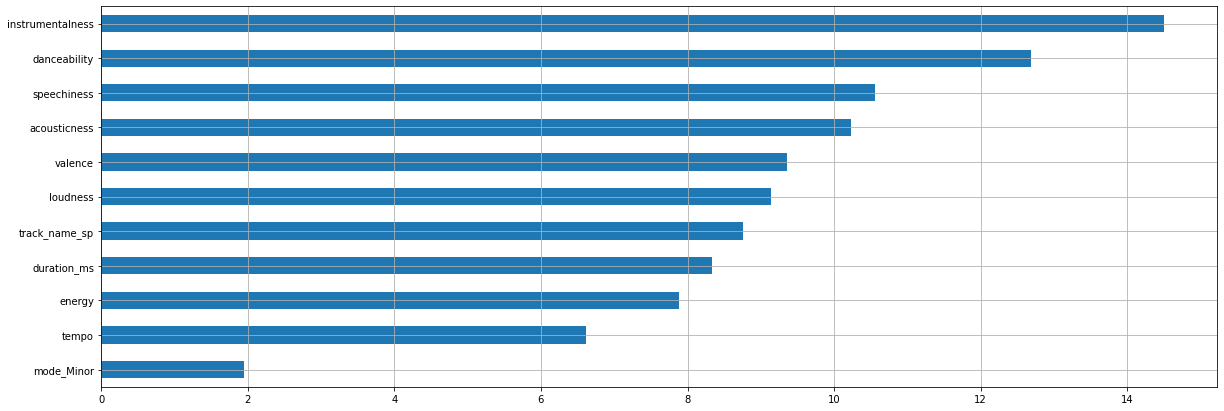

In [118]:
# строим график важности признаков CatBoost
pd.Series(model_CatBoost.feature_importances_, index=model_CatBoost.feature_names_)\
            .sort_values(ascending=True).plot.barh(figsize=(20,7), grid=True);

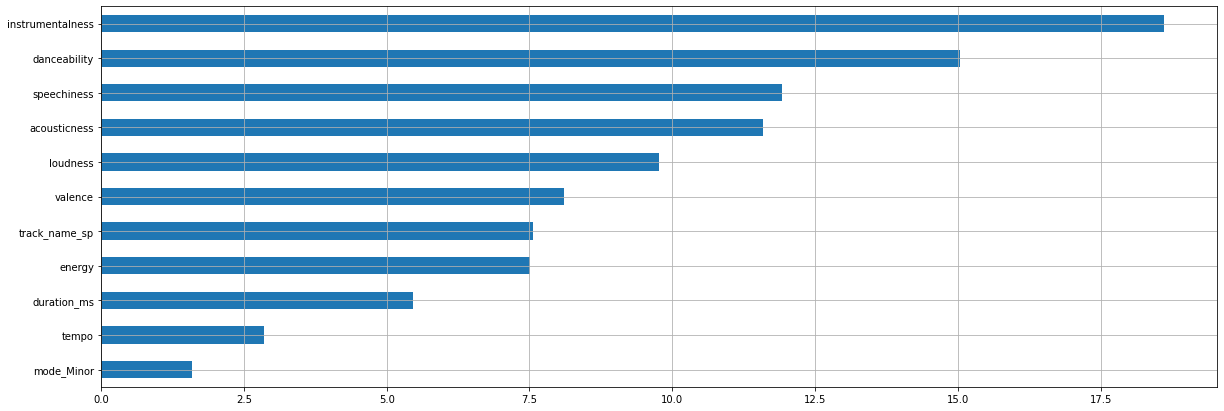

In [119]:
# строим график важности признаков CatBoost
pd.Series(model_CatBoost_Hgrid.feature_importances_, index=model_CatBoost_Hgrid.feature_names_)\
            .sort_values(ascending=True).plot.barh(figsize=(20,7), grid=True);

## Вывод


-  Наиболее важным признаком для CatBoost является 'instrumentalness'. Видимо, модель вокальность делит жанры на наиболее понятные для модели кластеры. 


-  Наименее важым признаком из отобранных, предсказуемо, оказался 'mode' - признак принимает всего два значения, один из которых удален при шифровании.      


-  В пятерку самых важных признаков входят 'instrumentalness', 'danceability',  'speechiness', 'acousticness' и 'loudness'.

-  Важность одних и тех же признаков при обучении без подбора и при подборе гиперпараметров для одной и той же модели отличается.


# Общий вывод 

-  В процессе работы над проектом, мы:

    - Загрузили и изучили данные;
        
    - Провели предобработку и разведочный анализ;
    
    - Создали и добавили новые признаки;
    
    - Проверили признаки на мультиколлинеарность;
    
    - Отобрали и подготовли признаки для обучения;
        
    - Выбраи и обучили модели ML, подобрав для них лучшие гиперпараметры;
    
    - Оценили качество предсказаний моделей (по метрике F1) кросс-валидацией; 
    
    - Проанализировали важность признаков лучшей модели;
    
    - Сформулировали и оформили промежуточный и общий выводы.



- **Резюме**: 
       
     - Лучше всего с поставленной задачей справилась **модель CatBoost** с количеством итерций (iterations) 2000, и 'learning_rate'  - 0.03. Модель показала на валидационной выборке значение метрики **F1 - 0.480479**, это значит, что модель правильно предсказала жанр(один из десяти) трека почти в половине случаев. 
     
     - **Наиболее важным признаком** для модели является **'instrumentalness'**.     


# Доп. Добавление предсказания к тестовой выборке

In [120]:
# получаем предсказание лучшей модели на тестовой выборке 
predicted_test_CB = model_CatBoost.predict(df_test)

In [121]:
# декодируем предсказание
predicted_test_CB = labelencoder.inverse_transform(np.ravel(predicted_test_CB))

In [122]:
# копируем контрольный датасет 
sample_submit_CB = sample_submit

In [123]:
# добавляяем предсказание в контрольный датасет
sample_submit_CB['music_genre'] = predicted_test_CB

In [124]:
# проверяем
display(sample_submit_CB.head())

,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative


In [125]:
# выгружаем файл
sample_submit_CB.to_csv('../Downloads/sample_submit_CB.csv', index=False)